# 第六週：分析PTT軟體工作版相關文章之詞彙關係
課程為「文辭和文件分析」，目的為透過TF-IDF, N-gram等方法找出文章以及字詞間的關聯。

這裡將會以軟體工程師版的文章做為分析資料。



動機： 由於我們未來有比較大的可能從事軟體相關的工作，因此細部討論軟體版

目標： 觀察關係相近詞彙是否能歸類同一主題

遇到的困難和解決方法：
1. 許多無用字不存在停用字字典中或亂碼難以被篩選掉
    - 透過n-gram盡量優化自定義的斷詞字典以及逐個更新停用字字典
2. 有部分陌生詞彙不太理解其代表意思
    - 查看原始資料集，從上下文語意來判斷
3. 在進行圖表視覺化時，預設的中文字型無法正常顯示
    - 從網路上下載解壓縮後的字型檔後再加載進去

## 大綱
1. 套件說明
2. 資料前處理
    - 2.1 基本資料介紹
    - 2.2 資料清理
    - 2.3 文章斷詞與整理
3. 找出重要詞彙 - 以TFIDF為例
    - 3.1 計算TF-IDF示範（公式）
    - 3.2 應用於資料集（套件）
    - 3.3 檢視結果
4.  透過結巴斷詞與N-gram幫助建立斷詞字典
    - 4.1 Bigram
    - 4.2 Trigram
    - 4.3 更新斷詞字典
    - 4.4 Bigram視覺化
5.  Pairwise correlation
    - 5.1 找出相關性高的詞彙
    - 5.2 畫出關係圖
6. 計算文章相似度
7. 補充：建立Ngram預測模型


## 1. 套件說明

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import jieba
import jieba.analyse
import math
from nltk import ngrams, FreqDist
from collections import Counter, namedtuple

import networkx as nx
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
from sklearn.metrics.pairwise import cosine_similarity


In [6]:
# # 設定圖的中文字體 (無法顯示的話可以試試‘Microsoft JhengHei’字體)
# # 也可參考：https://pyecontech.com/2020/03/27/python_matplotlib_chinese/
# plt.rcParams['font.sans-serif'] = ['Arial Unicode Ms'] #使圖中中文能正常顯示
# plt.rcParams['axes.unicode_minus'] = False #使負號能夠顯示

# 微軟正黑體
# !apt-get -y install fonts-noto-cjk
# plt.rcParams['font.sans-serif'] = ['Noto Sans CJK TC']
# plt.rcParams['axes.unicode_minus'] = False

原本用作業的方法沒辦法顯示中文，所以換個方法直接下載網路上的字型並做解壓縮後再匯入matplotlib套件。

In [64]:
import matplotlib
# cloab 字體設定

!wget -O taipei_sans_tc_beta.ttf https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_&export=download

# 新增字體
matplotlib.font_manager.fontManager.addfont('taipei_sans_tc_beta.ttf')

# 將 font-family 設為 Taipei Sans TC Beta
# 設定完後，之後的圖表都可以顯示中文了
matplotlib.rc('font', family='Taipei Sans TC Beta')

--2025-04-17 07:02:48--  https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_
Resolving drive.google.com (drive.google.com)... 64.233.179.138, 64.233.179.101, 64.233.179.100, ...
Connecting to drive.google.com (drive.google.com)|64.233.179.138|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_ [following]
--2025-04-17 07:02:48--  https://drive.usercontent.google.com/download?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 74.125.69.132, 2607:f8b0:4001:c01::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|74.125.69.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20659344 (20M) [application/octet-stream]
Saving to: ‘taipei_sans_tc_beta.ttf’

taipei_sans_tc_beta 100%[===================>]  19.70M   129MB/s    in 0.2s    

2025-04-17 07:02:51 (129

## 2. 資料前處理

### 2.1 基本資料介紹
資料來源：
+ 工作流程平台蒐集PTT 軟體工作版(Soft_Job)文章
+ 關鍵字:
+ 時間: 2023-01-01 ~ 2025-03-31
+ 資料筆數：共 1547 篇文章

In [8]:
# 下載 GitHub 中的 dataset
!git clone https://github.com/leo85741/dataset.git
%cd dataset
!unzip softjob_23_25.csv.zip

Cloning into 'dataset'...
remote: Enumerating objects: 25, done.
remote: Counting objects: 100% (25/25), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 25 (delta 2), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (25/25), 7.19 MiB | 14.56 MiB/s, done.
Resolving deltas: 100% (2/2), done.
/content/dataset
Archive:  softjob_23_25.csv.zip
  inflating: softjob_23_25.csv       
  inflating: __MACOSX/._softjob_23_25.csv  


In [9]:
#匯入資料
df = pd.read_csv('softjob_23_25.csv', encoding = 'UTF-8')
df.head(3)

system_id                                             artUrl  \
0          1  https://www.ptt.cc/bbs/Soft_Job/M.1672537150.A...   
1          2  https://www.ptt.cc/bbs/Soft_Job/M.1672559293.A...   
2          3  https://www.ptt.cc/bbs/Soft_Job/M.1672571470.A...   

                 artTitle              artDate   artPoster artCatagory  \
0  [分享]系統設計:如何取消正在執行的工作任務  2023-01-01 09:39:03  appleboy46    Soft_Job   
1      [請益]北漂Offer金融vs假外商  2023-01-01 15:48:11    carsun00    Soft_Job   
2   [請益]有人的公司也沒有提供API文件的嗎  2023-01-01 19:11:08    cv123741    Soft_Job   

                                          artContent  \
0  文字教學:\nhttps://bit.ly/3jFMwvS\n教學影片:\nhttps://...   
1  背景：\n  私立資工學士\n  軟體經驗5Y，後端為主，可以支援前端/CICD\n\n  ...   
2  安安\n\n小弟剛轉前端，進到一家接案公司寫網頁，工作大概9成都在接API，\n但公司內部沒...   

                                          artComment            e_ip  \
0  [{"cmtStatus": "→", "cmtPoster": "loadingN", "...  123.110.136.13   
1  [{"cmtStatus": "推", "cmtPoster": "xyzb", "cmtC...  111.252.104.32   
2  [{"cmtStatus": "推", "cmtPoster": "newbout", "c...    112.78.88.96   

          insertedDate dataSource  
0  2023-01-02 02:02:59        ptt  
1  2023-01-02 02:02:59        ptt  
2  2023-01-02 02:03:00        ptt

### 2.2 資料清理  
- 去除特殊字元與標點符號，只留下中文字
- \u4e00-\u9fff 為Unicode中文漢字字符的範圍

In [10]:
MetaData = df.copy()

# 去除一些不需要的欄位
MetaData = MetaData.drop(['artPoster', 'artCatagory', 'artComment', 'e_ip', 'insertedDate', 'dataSource'], axis=1)
# 只留下中文字 (artContent -> sentence)
MetaData['sentence'] = MetaData['artContent'].apply(lambda x: re.sub('[^\u4e00-\u9fff]+', '', str(x)) if isinstance(x, str) else '')

MetaData.head(3)

system_id                                             artUrl  \
0          1  https://www.ptt.cc/bbs/Soft_Job/M.1672537150.A...   
1          2  https://www.ptt.cc/bbs/Soft_Job/M.1672559293.A...   
2          3  https://www.ptt.cc/bbs/Soft_Job/M.1672571470.A...   

                 artTitle              artDate  \
0  [分享]系統設計:如何取消正在執行的工作任務  2023-01-01 09:39:03   
1      [請益]北漂Offer金融vs假外商  2023-01-01 15:48:11   
2   [請益]有人的公司也沒有提供API文件的嗎  2023-01-01 19:11:08   

                                          artContent  \
0  文字教學:\nhttps://bit.ly/3jFMwvS\n教學影片:\nhttps://...   
1  背景：\n  私立資工學士\n  軟體經驗5Y，後端為主，可以支援前端/CICD\n\n  ...   
2  安安\n\n小弟剛轉前端，進到一家接案公司寫網頁，工作大概9成都在接API，\n但公司內部沒...   

                                            sentence  
0  文字教學教學影片範例程式系統架構圖本篇來聊聊如何取消正在執行的工作任務當系統內有需要處理比較...  
1  背景私立資工學士軟體經驗後端為主可以支援前端是碩士價廢牡蠣假外商單位產險體系資融金融顧問部分...  
2  安安小弟剛轉前端進到一家接案公司寫網頁工作大概成都在接但公司內部沒有提供規格文件讓我參考導致...

### 2.3 文章斷詞與整理

In [11]:
# 設定繁體中文詞庫
jieba.set_dictionary('./dict/dict.txt.big')

# 新增stopwords
with open('./dict/stopwords.txt',encoding="utf-8") as f:
    stopWords = [line.strip() for line in f.readlines()]

In [71]:
# 設定斷詞 function
def getToken(row):
    seg_list = jieba.lcut(row)

    exclude_words = {'一三五', '一一列舉', '真的', '</s>'}
    seg_list = [
        w for w in seg_list
        if w not in stopWords
        and len(w) > 1
        and not re.match(r'(.)\1+$', w)     # 篩掉重複字詞
        and w not in exclude_words          # 自訂排除
        # and not w.startswith('一')
    ]

    return seg_list

In [72]:
data = MetaData.copy()

# 斷詞、去除停用字並將word欄位展開
# data['word'] = data.sentence.apply(getToken).explode('word')

data['word'] = data['sentence'].apply(getToken)
data = data.explode('word')
data.head(3)

system_id                                             artUrl  \
0          1  https://www.ptt.cc/bbs/Soft_Job/M.1672537150.A...   
0          1  https://www.ptt.cc/bbs/Soft_Job/M.1672537150.A...   
0          1  https://www.ptt.cc/bbs/Soft_Job/M.1672537150.A...   

                 artTitle              artDate  \
0  [分享]系統設計:如何取消正在執行的工作任務  2023-01-01 09:39:03   
0  [分享]系統設計:如何取消正在執行的工作任務  2023-01-01 09:39:03   
0  [分享]系統設計:如何取消正在執行的工作任務  2023-01-01 09:39:03   

                                          artContent  \
0  文字教學:\nhttps://bit.ly/3jFMwvS\n教學影片:\nhttps://...   
0  文字教學:\nhttps://bit.ly/3jFMwvS\n教學影片:\nhttps://...   
0  文字教學:\nhttps://bit.ly/3jFMwvS\n教學影片:\nhttps://...   

                                            sentence word  
0  文字教學教學影片範例程式系統架構圖本篇來聊聊如何取消正在執行的工作任務當系統內有需要處理比較...   文字  
0  文字教學教學影片範例程式系統架構圖本篇來聊聊如何取消正在執行的工作任務當系統內有需要處理比較...   教學  
0  文字教學教學影片範例程式系統架構圖本篇來聊聊如何取消正在執行的工作任務當系統內有需要處理比較...   教學

In [73]:
data

system_id                                             artUrl  \
0             1  https://www.ptt.cc/bbs/Soft_Job/M.1672537150.A...   
0             1  https://www.ptt.cc/bbs/Soft_Job/M.1672537150.A...   
0             1  https://www.ptt.cc/bbs/Soft_Job/M.1672537150.A...   
0             1  https://www.ptt.cc/bbs/Soft_Job/M.1672537150.A...   
0             1  https://www.ptt.cc/bbs/Soft_Job/M.1672537150.A...   
...         ...                                                ...   
1546       1547  https://www.ptt.cc/bbs/Soft_Job/M.1743354201.A...   
1546       1547  https://www.ptt.cc/bbs/Soft_Job/M.1743354201.A...   
1546       1547  https://www.ptt.cc/bbs/Soft_Job/M.1743354201.A...   
1546       1547  https://www.ptt.cc/bbs/Soft_Job/M.1743354201.A...   
1546       1547  https://www.ptt.cc/bbs/Soft_Job/M.1743354201.A...   

                    artTitle              artDate  \
0     [分享]系統設計:如何取消正在執行的工作任務  2023-01-01 09:39:03   
0     [分享]系統設計:如何取消正在執行的工作任務  2023-01-01 09:39:03   
0     [分享]系統設計:如何取消正在執行的工作任務  2023-01-01 09:39:03   
0     [分享]系統設計:如何取消正在執行的工作任務  2023-01-01 09:39:03   
0     [分享]系統設計:如何取消正在執行的工作任務  2023-01-01 09:39:03   
...                      ...                  ...   
1546          [心得]8年的博弈業工作心得  2025-03-31 01:03:18   
1546          [心得]8年的博弈業工作心得  2025-03-31 01:03:18   
1546          [心得]8年的博弈業工作心得  2025-03-31 01:03:18   
1546          [心得]8年的博弈業工作心得  2025-03-31 01:03:18   
1546          [心得]8年的博弈業工作心得  2025-03-31 01:03:18   

                                             artContent  \
0     文字教學:\nhttps://bit.ly/3jFMwvS\n教學影片:\nhttps://...   
0     文字教學:\nhttps://bit.ly/3jFMwvS\n教學影片:\nhttps://...   
0     文字教學:\nhttps://bit.ly/3jFMwvS\n教學影片:\nhttps://...   
0     文字教學:\nhttps://bit.ly/3jFMwvS\n教學影片:\nhttps://...   
0     文字教學:\nhttps://bit.ly/3jFMwvS\n教學影片:\nhttps://...   
...                                                 ...   
1546  受惠軟體開發板各位大大分享，我也來分享一些在博弈軟體開發工作的心得\n\n網頁好讀版\nht...   
1546  受惠軟體開發板各位大大分享，我也來分享一些在博弈軟體開發工作的心得\n\n網頁好讀版\nht...   
1546  受惠軟體開發板各位大大分享，我也來分享一些在博弈軟體開發工作的心得\n\n網頁好讀版\nht...   
1546  受惠軟體開發板各位大大分享，我也來分享一些在博弈軟體開發工作的心得\n\n網頁好讀版\nht...   
1546  受惠軟體開發板各位大大分享，我也來分享一些在博弈軟體開發工作的心得\n\n網頁好讀版\nht...   

                                               sentence word  
0     文字教學教學影片範例程式系統架構圖本篇來聊聊如何取消正在執行的工作任務當系統內有需要處理比較...   文字  
0     文字教學教學影片範例程式系統架構圖本篇來聊聊如何取消正在執行的工作任務當系統內有需要處理比較...   教學  
0     文字教學教學影片範例程式系統架構圖本篇來聊聊如何取消正在執行的工作任務當系統內有需要處理比較...   教學  
0     文字教學教學影片範例程式系統架構圖本篇來聊聊如何取消正在執行的工作任務當系統內有需要處理比較...   影片  
0     文字教學教學影片範例程式系統架構圖本篇來聊聊如何取消正在執行的工作任務當系統內有需要處理比較...   範例  
...                                                 ...  ...  
1546  受惠軟體開發板各位大大分享我也來分享一些在博弈軟體開發工作的心得網頁好讀版從事軟體開發也有年...   猶豫  
1546  受惠軟體開發板各位大大分享我也來分享一些在博弈軟體開發工作的心得網頁好讀版從事軟體開發也有年...   博弈  
1546  受惠軟體開發板各位大大分享我也來分享一些在博弈軟體開發工作的心得網頁好讀版從事軟體開發也有年...   軟體  
1546  受惠軟體開發板各位大大分享我也來分享一些在博弈軟體開發工作的心得網頁好讀版從事軟體開發也有年...   開發  
1546  受惠軟體開發板各位大大分享我也來分享一些在博弈軟體開發工作的心得網頁好讀版從事軟體開發也有年...   工作  

[168854 rows x 7 columns]

## 3. 找出重要詞彙 - 以TFIDF為例

TF-IDF 是一種統計方法，可用來評估單詞對於文件的集合的重要程度  
- **TF** (Term Frequency)：某一個詞彙在某一個文件中所出現的頻率  
    - TF = 詞彙在該文件中出現次數 / 該文件中詞彙總數  
- **IDF** (Inverse Document Frequent)：為文件數除以某特定詞彙有被多少文件所提及的數量取log  
    - IDF = log( 總文件數量 / 包含該詞彙的文件數量 )

### 3.1 計算TF-IDF

使用sklearn中計算詞頻與tf-idf的套件。

DTM

Document term matrix (DTM)，是一種用於自然語言處理的數學矩陣，描述了在一組文件中各個詞彙出現的頻率。
DTM 中的每一行代表一個文件(Document)，每一列代表一個詞彙(Term)，每一格的值表示該詞彙在該文件中的出現次數。

In [74]:
softjob_df = MetaData.copy()
softjob_df.head(3)

system_id                                             artUrl  \
0          1  https://www.ptt.cc/bbs/Soft_Job/M.1672537150.A...   
1          2  https://www.ptt.cc/bbs/Soft_Job/M.1672559293.A...   
2          3  https://www.ptt.cc/bbs/Soft_Job/M.1672571470.A...   

                 artTitle              artDate  \
0  [分享]系統設計:如何取消正在執行的工作任務  2023-01-01 09:39:03   
1      [請益]北漂Offer金融vs假外商  2023-01-01 15:48:11   
2   [請益]有人的公司也沒有提供API文件的嗎  2023-01-01 19:11:08   

                                          artContent  \
0  文字教學:\nhttps://bit.ly/3jFMwvS\n教學影片:\nhttps://...   
1  背景：\n  私立資工學士\n  軟體經驗5Y，後端為主，可以支援前端/CICD\n\n  ...   
2  安安\n\n小弟剛轉前端，進到一家接案公司寫網頁，工作大概9成都在接API，\n但公司內部沒...   

                                            sentence  
0  文字教學教學影片範例程式系統架構圖本篇來聊聊如何取消正在執行的工作任務當系統內有需要處理比較...  
1  背景私立資工學士軟體經驗後端為主可以支援前端是碩士價廢牡蠣假外商單位產險體系資融金融顧問部分...  
2  安安小弟剛轉前端進到一家接案公司寫網頁工作大概成都在接但公司內部沒有提供規格文件讓我參考導致...

In [75]:
# 留下要用到的欄位
softjob_df = softjob_df.loc[:,["system_id", "sentence"]]

# 使用空格連接斷完的詞
softjob_df['word'] = softjob_df.sentence.apply(getToken).map(' '.join)

softjob_df.head()

system_id                                           sentence  \
0          1  文字教學教學影片範例程式系統架構圖本篇來聊聊如何取消正在執行的工作任務當系統內有需要處理比較...   
1          2  背景私立資工學士軟體經驗後端為主可以支援前端是碩士價廢牡蠣假外商單位產險體系資融金融顧問部分...   
2          3  安安小弟剛轉前端進到一家接案公司寫網頁工作大概成都在接但公司內部沒有提供規格文件讓我參考導致...   
3          4  幾種可能做法寫在假如有用開給後端做請後端完成後將他測試時的貼上去這對新應該沒什麼問題舊有的就...   
4          5  從網路上的資訊得知如果是從事韌體開發則用的都是如果是從事開發則用的都是之類的語言那麼的發展空...   

                                                word  
0  文字 教學 教學 影片 範例 程式 系統 架構圖 本篇 取消 執行 工作 系統 內有 資源 ...  
1  背景 私立 資工 學士 軟體 經驗 支援 前端 碩士 價廢 牡蠣 外商 單位 產險 體系 資...  
2  小弟 剛轉 前端 一家 接案 公司 網頁 工作 成都 公司 內部 提供 規格 文件 參考 導...  
3  幾種 做法 有用 開給後端 請後端 將他 測試 貼上去 這對 沒什麼 舊有 記在 帳號 下次...  
4            網路上 資訊 得知 韌體 開發 則用 開發 則用 語言 發展 空間 領域 有人

In [76]:
# Bag of Word
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(softjob_df["word"])
vocabulary = vectorizer.get_feature_names_out()

# 轉成 dataframe
DTM_df = pd.DataFrame(columns = vocabulary, data = X.toarray())
DTM_df

一下下  一下全部  一下子  一不小心  一不鳥  一並  一串  一事無成  一二  一二一  ...  齊聚一堂  龍年  龍心  龍滑  \
0       0     0    0     0    0   0   0     0   0    0  ...     0   0   0   0   
1       0     0    0     0    0   0   0     0   0    0  ...     0   0   0   0   
2       0     0    0     0    0   0   0     0   0    0  ...     0   0   0   0   
3       0     0    0     0    0   0   0     0   0    0  ...     0   0   0   0   
4       0     0    0     0    0   0   0     0   0    0  ...     0   0   0   0   
...   ...   ...  ...   ...  ...  ..  ..   ...  ..  ...  ...   ...  ..  ..  ..   
1542    0     0    0     0    0   0   0     0   0    0  ...     0   0   0   0   
1543    0     0    0     0    0   0   0     0   0    0  ...     0   0   0   0   
1544    0     0    0     0    0   0   0     0   0    0  ...     0   0   0   0   
1545    0     0    0     0    0   0   0     0   0    0  ...     0   0   0   0   
1546    0     0    0     0    0   0   0     0   0    0  ...     0   0   0   0   

      龍潭  龍頭  龐大  龜大  龜山  龜毛  
0      0   0   0   0   0   0  
1      0   0   0   0   0   0  
2      0   0   0   0   0   0  
3      0   0   0   0   0   0  
4      0   0   0   0   0   0  
...   ..  ..  ..  ..  ..  ..  
1542   0   0   0   0   0   0  
1543   0   0   0   0   0   0  
1544   0   0   0   0   0   0  
1545   0   0   0   0   0   0  
1546   0   0   0   0   0   0  

[1547 rows x 24580 columns]

In [77]:
transformer = TfidfTransformer()
# 將詞頻矩陣X統計成TF-IDF值
tfidf = transformer.fit_transform(X)

# 轉成dataframe
TFIDF_df = pd.DataFrame(columns = vocabulary, data = tfidf.toarray())

TFIDF_df

一下下  一下全部  一下子  一不小心  一不鳥   一並   一串  一事無成   一二  一二一  ...  齊聚一堂   龍年  \
0     0.0   0.0  0.0   0.0  0.0  0.0  0.0   0.0  0.0  0.0  ...   0.0  0.0   
1     0.0   0.0  0.0   0.0  0.0  0.0  0.0   0.0  0.0  0.0  ...   0.0  0.0   
2     0.0   0.0  0.0   0.0  0.0  0.0  0.0   0.0  0.0  0.0  ...   0.0  0.0   
3     0.0   0.0  0.0   0.0  0.0  0.0  0.0   0.0  0.0  0.0  ...   0.0  0.0   
4     0.0   0.0  0.0   0.0  0.0  0.0  0.0   0.0  0.0  0.0  ...   0.0  0.0   
...   ...   ...  ...   ...  ...  ...  ...   ...  ...  ...  ...   ...  ...   
1542  0.0   0.0  0.0   0.0  0.0  0.0  0.0   0.0  0.0  0.0  ...   0.0  0.0   
1543  0.0   0.0  0.0   0.0  0.0  0.0  0.0   0.0  0.0  0.0  ...   0.0  0.0   
1544  0.0   0.0  0.0   0.0  0.0  0.0  0.0   0.0  0.0  0.0  ...   0.0  0.0   
1545  0.0   0.0  0.0   0.0  0.0  0.0  0.0   0.0  0.0  0.0  ...   0.0  0.0   
1546  0.0   0.0  0.0   0.0  0.0  0.0  0.0   0.0  0.0  0.0  ...   0.0  0.0   

       龍心   龍滑   龍潭   龍頭   龐大   龜大   龜山   龜毛  
0     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
1     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
3     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
4     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
...   ...  ...  ...  ...  ...  ...  ...  ...  
1542  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
1543  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
1544  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
1545  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
1546  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[1547 rows x 24580 columns]

### 3.2 檢視結果   
根據tfidf值來挑出重要詞彙：
1. 取每一個字詞在所有文件裡的TF-IDF平均值
2. 取每份文件裡TF-IDF值最大的前10個字詞當為常用字詞，再取每一個字詞在常用字詞中出現頻率

#### 方法1： 取每一個字詞在所有文件裡的TF-IDF平均值

In [78]:
softjob_tfidf = TFIDF_df.mean().to_frame().reset_index() ## !!
softjob_tfidf.columns = ["word", "avg"]

softjob_tfidf.sort_values('avg', ascending = False).head(10)

word       avg
3484    公司  0.041759
8525    工作  0.030058
23816   面試  0.025904
23082   開發  0.020176
8582   工程師  0.018448
10634   技術  0.018176
16857   程式  0.016935
12423   時間  0.016600
17469   系統  0.015202
21324   軟體  0.015185

#### 方法2： 取每份文件裡TF-IDF值最大的前10個字詞當為常用字詞，再取每一個字詞在常用字詞中出現頻率

In [79]:
toptens = TFIDF_df.copy()
toptens.insert(0, 'doc_id', toptens.index+1)

toptens

doc_id  一下下  一下全部  一下子  一不小心  一不鳥   一並   一串  一事無成   一二  ...  齊聚一堂   龍年  \
0          1  0.0   0.0  0.0   0.0  0.0  0.0  0.0   0.0  0.0  ...   0.0  0.0   
1          2  0.0   0.0  0.0   0.0  0.0  0.0  0.0   0.0  0.0  ...   0.0  0.0   
2          3  0.0   0.0  0.0   0.0  0.0  0.0  0.0   0.0  0.0  ...   0.0  0.0   
3          4  0.0   0.0  0.0   0.0  0.0  0.0  0.0   0.0  0.0  ...   0.0  0.0   
4          5  0.0   0.0  0.0   0.0  0.0  0.0  0.0   0.0  0.0  ...   0.0  0.0   
...      ...  ...   ...  ...   ...  ...  ...  ...   ...  ...  ...   ...  ...   
1542    1543  0.0   0.0  0.0   0.0  0.0  0.0  0.0   0.0  0.0  ...   0.0  0.0   
1543    1544  0.0   0.0  0.0   0.0  0.0  0.0  0.0   0.0  0.0  ...   0.0  0.0   
1544    1545  0.0   0.0  0.0   0.0  0.0  0.0  0.0   0.0  0.0  ...   0.0  0.0   
1545    1546  0.0   0.0  0.0   0.0  0.0  0.0  0.0   0.0  0.0  ...   0.0  0.0   
1546    1547  0.0   0.0  0.0   0.0  0.0  0.0  0.0   0.0  0.0  ...   0.0  0.0   

       龍心   龍滑   龍潭   龍頭   龐大   龜大   龜山   龜毛  
0     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
1     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
3     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
4     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
...   ...  ...  ...  ...  ...  ...  ...  ...  
1542  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
1543  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
1544  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
1545  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
1546  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[1547 rows x 24581 columns]

In [80]:
toptens = toptens.melt(id_vars = "doc_id", var_name = "word", value_name = 'tfidf')
toptens

doc_id word  tfidf
0              1  一下下    0.0
1              2  一下下    0.0
2              3  一下下    0.0
3              4  一下下    0.0
4              5  一下下    0.0
...          ...  ...    ...
38025255    1543   龜毛    0.0
38025256    1544   龜毛    0.0
38025257    1545   龜毛    0.0
38025258    1546   龜毛    0.0
38025259    1547   龜毛    0.0

[38025260 rows x 3 columns]

In [81]:
(
    # 從每篇文章挑選出tf-idf最大的前十個詞
    toptens.groupby("doc_id").apply(lambda x : x.nlargest(10, "tfidf")).reset_index(drop=True)

    # 計算每個詞被選中的次數
    .groupby(['word'],as_index=False).size()

).sort_values('size', ascending=False).head(10) # 排序看前十名


<ipython-input-81-1a4971485870>:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  toptens.groupby("doc_id").apply(lambda x : x.nlargest(10, "tfidf")).reset_index(drop=True)


word  size
1334    公司   111
8086    面試    76
0      一下下    53
7891    開發    53
3160    工作    48
6156    系統    45
1     一下全部    43
3924    技術    42
3193   工程師    35
2023    台灣    34

以上結果可以發現討論的焦點都是軟體工程師、工作相關的字眼，如 面試、工作、程式、系統開發等等。

## 4. 透過結巴斷詞與N-gram幫助建立斷詞字典
N-gram 指文本中連續出現的n個語詞。   
透過N-gram我們可以找出有哪些詞彙較常一起出現，檢查是否需要加入自定義字典中。   

### 4.1 Bigram

In [82]:
# 設定 ngram 斷詞 function
def ngram_getToken(row, n):
    # 進行斷詞
    seg_list = jieba.lcut(row)

    # 篩選掉停用字與字元數小於1的詞彙
    seg_list = [w for w in seg_list if w not in stopWords and len(w)>1]

    # ngram斷詞
    seg_list = ngrams(seg_list, n)
    seg_list = [" ".join(w) for w in list(seg_list)]

    return seg_list

In [83]:
softjob_bigram = MetaData.copy()

softjob_bigram["word"] = softjob_bigram['sentence'].apply(lambda row: ngram_getToken(row, 2))
softjob_bigram = softjob_bigram.explode('word')

softjob_bigram.head(3)

system_id                                             artUrl  \
0          1  https://www.ptt.cc/bbs/Soft_Job/M.1672537150.A...   
0          1  https://www.ptt.cc/bbs/Soft_Job/M.1672537150.A...   
0          1  https://www.ptt.cc/bbs/Soft_Job/M.1672537150.A...   

                 artTitle              artDate  \
0  [分享]系統設計:如何取消正在執行的工作任務  2023-01-01 09:39:03   
0  [分享]系統設計:如何取消正在執行的工作任務  2023-01-01 09:39:03   
0  [分享]系統設計:如何取消正在執行的工作任務  2023-01-01 09:39:03   

                                          artContent  \
0  文字教學:\nhttps://bit.ly/3jFMwvS\n教學影片:\nhttps://...   
0  文字教學:\nhttps://bit.ly/3jFMwvS\n教學影片:\nhttps://...   
0  文字教學:\nhttps://bit.ly/3jFMwvS\n教學影片:\nhttps://...   

                                            sentence   word  
0  文字教學教學影片範例程式系統架構圖本篇來聊聊如何取消正在執行的工作任務當系統內有需要處理比較...  文字 教學  
0  文字教學教學影片範例程式系統架構圖本篇來聊聊如何取消正在執行的工作任務當系統內有需要處理比較...  教學 教學  
0  文字教學教學影片範例程式系統架構圖本篇來聊聊如何取消正在執行的工作任務當系統內有需要處理比較...  教學 影片

#### 統計最常出現的bigram組合

In [84]:
# 計算每個組合出現的次數
softjob_bigram_count = softjob_bigram['word'].value_counts().reset_index()

softjob_bigram_count.sort_values('count', ascending=False).head(10)

word  count
0    軟體 開發     83
1    自備 工具     82
2    員工 自備     81
3   加班費 制度     79
5  保證 最低年薪     72
4    能力 經歷     72
7  徵才 聯絡方式     71
6    薪資 保證     71
9  最低年薪 必填     68
8    必填 項目     68

In [85]:
softjob_bigram_count.sort_values('count', ascending=False).head(60) # 方便後續做lexicon

word  count
0      軟體 開發     83
1      自備 工具     82
2      員工 自備     81
3     加班費 制度     79
5    保證 最低年薪     72
4      能力 經歷     72
7    徵才 聯絡方式     71
6      薪資 保證     71
9    最低年薪 必填     68
8      必填 項目     68
10   每日 工作時間     66
11     職缺 能力     64
12     工作 福利     62
14     接案 公司     60
13     計算 方式     60
17     詳細 至號     59
15   公司名稱 統編     59
16     填寫 詳細     59
18     公司 介紹     58
19     薪資 月薪     57
20   每周 工作時間     57
21     註冊 可免     56
22   中華民國 註冊     56
23   統編 中華民國     56
24   年終獎金 計算     56
25     人資 徵才     55
30   工作環境 職缺     54
29     工具 薪資     54
28     職缺 團隊     54
27     團隊 介紹     54
26   公司地址 填寫     54
31     公司 分紅     50
32    資深 工程師     50
33     超過 小時     49
34     分紅 獎金     49
36     公司 公司     46
35   項目 年終獎金     46
37     面試 過程     44
38     公司 面試     43
39     面試 流程     41
40     面試 面試     41
41    第一份 工作     38
42    前端 工程師     38
43     新創 公司     37
44     相關 經驗     37
45     全薪 計算     37
46     邀約 面試     36
47     工時 每日     36
48     系統 設計     35
49    開發 工程師     34
50     中午 休息     34
51     這件 事情     34
53     科技 公司     33
54     系統 開發     33
52    程式 設計師     33
55  工作時間 加班費     32
56     技術 面試     32
57     開發 流程     32
58     公司 工作     32
59     內部 系統     31

### 4.2 Trigram

In [86]:
softjob_trigram = MetaData.copy()

softjob_trigram["word"] = softjob_trigram.sentence.apply(lambda row: ngram_getToken(row, 3))
softjob_trigram = softjob_trigram.explode('word')

softjob_trigram.head(3)

system_id                                             artUrl  \
0          1  https://www.ptt.cc/bbs/Soft_Job/M.1672537150.A...   
0          1  https://www.ptt.cc/bbs/Soft_Job/M.1672537150.A...   
0          1  https://www.ptt.cc/bbs/Soft_Job/M.1672537150.A...   

                 artTitle              artDate  \
0  [分享]系統設計:如何取消正在執行的工作任務  2023-01-01 09:39:03   
0  [分享]系統設計:如何取消正在執行的工作任務  2023-01-01 09:39:03   
0  [分享]系統設計:如何取消正在執行的工作任務  2023-01-01 09:39:03   

                                          artContent  \
0  文字教學:\nhttps://bit.ly/3jFMwvS\n教學影片:\nhttps://...   
0  文字教學:\nhttps://bit.ly/3jFMwvS\n教學影片:\nhttps://...   
0  文字教學:\nhttps://bit.ly/3jFMwvS\n教學影片:\nhttps://...   

                                            sentence      word  
0  文字教學教學影片範例程式系統架構圖本篇來聊聊如何取消正在執行的工作任務當系統內有需要處理比較...  文字 教學 教學  
0  文字教學教學影片範例程式系統架構圖本篇來聊聊如何取消正在執行的工作任務當系統內有需要處理比較...  教學 教學 影片  
0  文字教學教學影片範例程式系統架構圖本篇來聊聊如何取消正在執行的工作任務當系統內有需要處理比較...  教學 影片 範例

#### 統計最常出現的trigram組合

In [87]:
# 計算每個組合出現的次數
softjob_trigram_count = softjob_trigram['word'].value_counts().reset_index()

softjob_trigram_count.sort_values('count', ascending=False).head(10)

word  count
0      員工 自備 工具     81
1    薪資 保證 最低年薪     71
2    最低年薪 必填 項目     68
3    保證 最低年薪 必填     68
4      職缺 能力 經歷     64
5      填寫 詳細 至號     59
6    統編 中華民國 註冊     56
7    中華民國 註冊 可免     56
8    年終獎金 計算 方式     56
9  公司名稱 統編 中華民國     56

In [88]:
softjob_trigram_count.sort_values('count', ascending=False).head(40) # 方便後續做lexicon

word  count
0       員工 自備 工具     81
1     薪資 保證 最低年薪     71
2     最低年薪 必填 項目     68
3     保證 最低年薪 必填     68
4       職缺 能力 經歷     64
5       填寫 詳細 至號     59
6     統編 中華民國 註冊     56
7     中華民國 註冊 可免     56
8     年終獎金 計算 方式     56
9   公司名稱 統編 中華民國     56
10    人資 徵才 聯絡方式     55
11    公司地址 填寫 詳細     54
12    工作環境 職缺 團隊     54
13      自備 工具 薪資     54
14      職缺 團隊 介紹     54
15      公司 分紅 獎金     49
16    必填 項目 年終獎金     46
17    項目 年終獎金 計算     45
18    工時 每日 工作時間     35
19   工作時間 加班費 制度     31
20      工具 薪資 月薪     29
21    加班費 制度 勞基法     28
22   每周 工作時間 加班費     27
24      中午 休息 每周     27
23    休息 每周 工作時間     27
28     平日 小時 工資額     24
30      小時 以內 平日     24
29      以內 平日 小時     24
27     小時 工資額 加給     24
26    工作時間 小時 以內     24
25    延長 工作時間 小時     24
31     工時 加班費 必填     23
32     八小時 中午 休息     23
33     加班費 必填 不填     23
34      必填 不填 刪文     23
35   每日 工作時間 八小時     23
36      不填 刪文 水桶     23
37      刪文 水桶 工時     22
38   工作時間 八小時 中午     22
39      計算 方式 全薪     22

從上面的 bigram 和 trigram 的結果中，我們發現"餐廳 名稱"、"服務 人員"等詞可以組合在一起，所以我們增加自定義字典來幫助斷詞能更準確。  
我們將詞彙整理好存在 dict 文件夾中的 buffet_lexicon.txt 中。

### 4.3 使用自建字典

In [89]:
# 新增軟體工作相關自定義字典
jieba.load_userdict('./dict/softjob_lexicon.txt')

**使用自建辭典進行斷詞與計算**

In [90]:
# 剛才的斷詞結果沒有使用新增的辭典，因此我們重新進行斷詞
data2 = MetaData.copy()
data2['word'] = data2.sentence.apply(getToken)
data2 = data2.explode('word')

data2.head(3)

system_id                                             artUrl  \
0          1  https://www.ptt.cc/bbs/Soft_Job/M.1672537150.A...   
0          1  https://www.ptt.cc/bbs/Soft_Job/M.1672537150.A...   
0          1  https://www.ptt.cc/bbs/Soft_Job/M.1672537150.A...   

                 artTitle              artDate  \
0  [分享]系統設計:如何取消正在執行的工作任務  2023-01-01 09:39:03   
0  [分享]系統設計:如何取消正在執行的工作任務  2023-01-01 09:39:03   
0  [分享]系統設計:如何取消正在執行的工作任務  2023-01-01 09:39:03   

                                          artContent  \
0  文字教學:\nhttps://bit.ly/3jFMwvS\n教學影片:\nhttps://...   
0  文字教學:\nhttps://bit.ly/3jFMwvS\n教學影片:\nhttps://...   
0  文字教學:\nhttps://bit.ly/3jFMwvS\n教學影片:\nhttps://...   

                                            sentence word  
0  文字教學教學影片範例程式系統架構圖本篇來聊聊如何取消正在執行的工作任務當系統內有需要處理比較...   文字  
0  文字教學教學影片範例程式系統架構圖本篇來聊聊如何取消正在執行的工作任務當系統內有需要處理比較...   教學  
0  文字教學教學影片範例程式系統架構圖本篇來聊聊如何取消正在執行的工作任務當系統內有需要處理比較...   教學

### 4.4 Bigram視覺化

更新斷詞字典後重新進行bigram斷詞

In [91]:
bigramfdist = MetaData.copy()

bigramfdist["word"] = bigramfdist['sentence'].apply(lambda row: ngram_getToken(row, 2))
bigramfdist = bigramfdist.explode('word')

bigramfdist.head(3)

system_id                                             artUrl  \
0          1  https://www.ptt.cc/bbs/Soft_Job/M.1672537150.A...   
0          1  https://www.ptt.cc/bbs/Soft_Job/M.1672537150.A...   
0          1  https://www.ptt.cc/bbs/Soft_Job/M.1672537150.A...   

                 artTitle              artDate  \
0  [分享]系統設計:如何取消正在執行的工作任務  2023-01-01 09:39:03   
0  [分享]系統設計:如何取消正在執行的工作任務  2023-01-01 09:39:03   
0  [分享]系統設計:如何取消正在執行的工作任務  2023-01-01 09:39:03   

                                          artContent  \
0  文字教學:\nhttps://bit.ly/3jFMwvS\n教學影片:\nhttps://...   
0  文字教學:\nhttps://bit.ly/3jFMwvS\n教學影片:\nhttps://...   
0  文字教學:\nhttps://bit.ly/3jFMwvS\n教學影片:\nhttps://...   

                                            sentence   word  
0  文字教學教學影片範例程式系統架構圖本篇來聊聊如何取消正在執行的工作任務當系統內有需要處理比較...  文字 教學  
0  文字教學教學影片範例程式系統架構圖本篇來聊聊如何取消正在執行的工作任務當系統內有需要處理比較...  教學 教學  
0  文字教學教學影片範例程式系統架構圖本篇來聊聊如何取消正在執行的工作任務當系統內有需要處理比較...  教學 影片

In [92]:
bigramfdist['word'] = bigramfdist['word'].astype(str)

# 使用FreqDist 取得 bigram 斷詞 與 bigram 出現頻率
bigramfdist = FreqDist(bigramfdist['word'].apply(lambda x: tuple(x.split(' '))))
bigramfdist.most_common(5)

[(('軟體', '開發'), 83),
 (('自備', '工具'), 82),
 (('員工', '自備'), 81),
 (('加班費', '制度'), 79),
 (('能力', '經歷'), 72)]

針對重新斷詞後的bigram出現頻率最高的前50對進行視覺化，觀察文章的關鍵詞對

In [93]:
# 建立bigram和count的dictionary
# 這裡取最多的前50項
d = {k:v for k,v in bigramfdist.most_common(50)}

In [94]:
# Create network plot
G = nx.Graph()

# 建立 nodes 間的連結
for k, v in [d][0].items():
    G.add_edge(k[0], k[1], weight=v) # nodes：詞彙，weight：組合出現頻率

# 取得調整edge權重
weights = [w[2]['weight']*0.01 for w in  G.edges(data=True)]

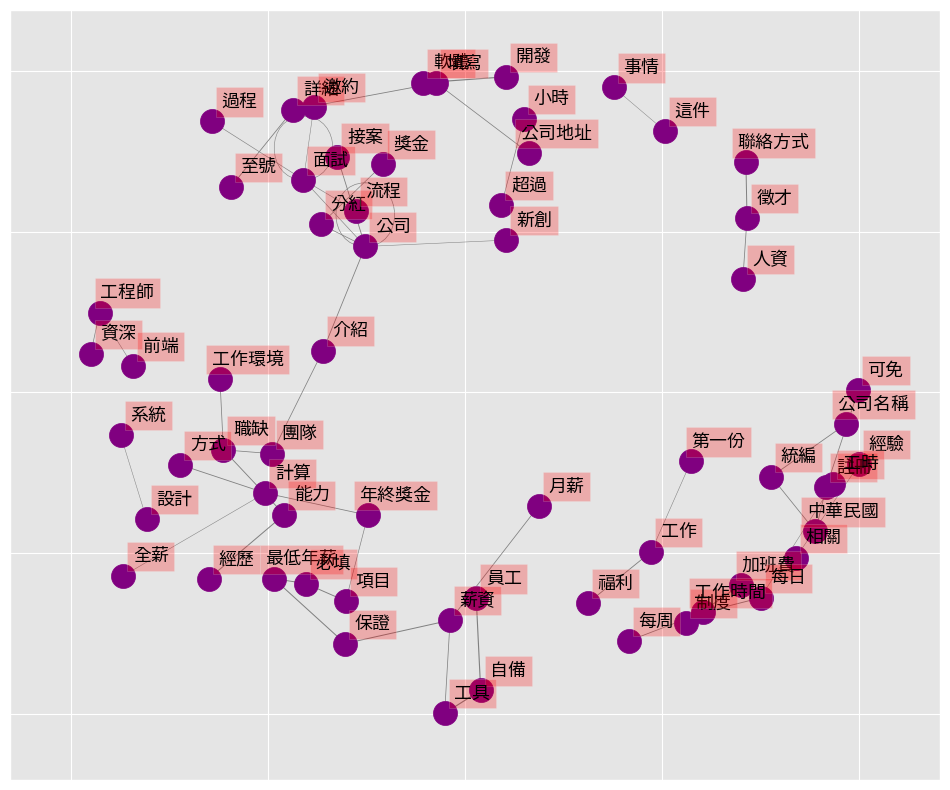

In [95]:
fig, ax = plt.subplots(figsize=(12, 10))

pos = nx.spring_layout(G, k=1.5)

# networks
nx.draw_networkx(G, pos,
                 font_size=16,
                 width=weights,
                 edge_color='grey',
                 node_color='purple',
                 with_labels = False,
                 ax=ax)

# 增加 labels
for key, value in pos.items():
    x, y = value[0]+.07, value[1]+.045
    ax.text(x, y,
            s=key,
            bbox=dict(facecolor='red', alpha=0.25),
            horizontalalignment='center', fontsize=13)

plt.show()

1. 左邊
* 是偏向「技術工作內容」的群組
  * 例如：工程師、團隊、工具、模型、前端、語言

2. 右下
* 這群跟「面試與薪資條件」有關
  * 例如：經驗、制度、福利

3. 右上
* 是「招募與行政」相關
  * 例如：人資、聯絡方式、制度、加班費、微才



## 5. Pairwise correlation
計算兩個詞彙間的相關性 Pearson correlation

In [96]:
data_cor = MetaData.copy()

# 需要改成使用空格連接斷好的詞
data_cor['word'] = data_cor.sentence.apply(getToken).map(' '.join)
data_cor.head(3)

system_id                                             artUrl  \
0          1  https://www.ptt.cc/bbs/Soft_Job/M.1672537150.A...   
1          2  https://www.ptt.cc/bbs/Soft_Job/M.1672559293.A...   
2          3  https://www.ptt.cc/bbs/Soft_Job/M.1672571470.A...   

                 artTitle              artDate  \
0  [分享]系統設計:如何取消正在執行的工作任務  2023-01-01 09:39:03   
1      [請益]北漂Offer金融vs假外商  2023-01-01 15:48:11   
2   [請益]有人的公司也沒有提供API文件的嗎  2023-01-01 19:11:08   

                                          artContent  \
0  文字教學:\nhttps://bit.ly/3jFMwvS\n教學影片:\nhttps://...   
1  背景：\n  私立資工學士\n  軟體經驗5Y，後端為主，可以支援前端/CICD\n\n  ...   
2  安安\n\n小弟剛轉前端，進到一家接案公司寫網頁，工作大概9成都在接API，\n但公司內部沒...   

                                            sentence  \
0  文字教學教學影片範例程式系統架構圖本篇來聊聊如何取消正在執行的工作任務當系統內有需要處理比較...   
1  背景私立資工學士軟體經驗後端為主可以支援前端是碩士價廢牡蠣假外商單位產險體系資融金融顧問部分...   
2  安安小弟剛轉前端進到一家接案公司寫網頁工作大概成都在接但公司內部沒有提供規格文件讓我參考導致...   

                                                word  
0  文字 教學 教學 影片 範例 程式 系統 架構圖 本篇 取消 執行 工作 系統 內有 資源 ...  
1  背景 私立 資工 學士 軟體 經驗 支援 前端 碩士 價廢 牡蠣 外商 單位 產險 體系 資...  
2  小弟 剛轉 前端 一家 接案 公司 網頁 工作 成都 公司 內部 提供 規格 文件 參考 導...

In [97]:
# Bag of Word
# 篩選至少出現在5篇文章以上且詞頻前300的詞彙
vectorizer = CountVectorizer(min_df = 5, max_features = 300)
X = vectorizer.fit_transform(data_cor["word"])
vocabulary = vectorizer.get_feature_names_out()

# 轉成dataframe
DTM_df = pd.DataFrame(columns = vocabulary, data = X.toarray())
DTM_df

一位  一個月  一堆  一家  一年  三個  上班  上課  下班  不好  ...  雲端  電腦  需求  面試  面試官  項目  \
0      0    0   0   0   0   0   0   0   0   0  ...   0   0   1   0    0   0   
1      0    0   0   0   0   0   1   0   0   0  ...   1   0   0   0    0   0   
2      0    0   0   1   0   0   0   0   0   0  ...   0   0   0   0    0   0   
3      0    0   0   0   0   0   0   0   0   0  ...   0   0   0   0    0   0   
4      0    0   0   0   0   0   0   0   0   0  ...   0   0   0   0    0   0   
...   ..  ...  ..  ..  ..  ..  ..  ..  ..  ..  ...  ..  ..  ..  ..  ...  ..   
1542   0    0   0   0   0   0   0   0   0   0  ...   0   0   0   0    0   0   
1543   0    0   0   0   1   0   0   0   0   1  ...   0   0   0   1    0   0   
1544   0    0   0   0   0   0   0   0   0   0  ...   0   0   0   0    0   0   
1545   0    0   0   0   0   0   0   0   0   0  ...   0   0   0   0    0   0   
1546   0    0   0   1   0   0   0   0   0   0  ...   0   0   2   0    0   0   

      領域  題目  類似  體驗  
0      0   0   0   0  
1      0   0   0   0  
2      0   0   0   0  
3      0   0   1   0  
4      1   0   0   0  
...   ..  ..  ..  ..  
1542   0   0   0   0  
1543   0   0   0   0  
1544   0   0   0   0  
1545   0   0   0   0  
1546   0   0   0   0  

[1547 rows x 300 columns]

In [98]:
# 計算詞之間的相關係數
corr_matrix = np.corrcoef(DTM_df.T)

# 轉成dataframe
Cor_df = pd.DataFrame(corr_matrix, index = DTM_df.columns, columns = DTM_df.columns)

Cor_df.insert(0, 'word1', Cor_df.columns)
Cor_df.reset_index(inplace = True, drop = True)

Cor_df

word1        一位       一個月            一堆        一家        一年        三個  \
0      一位  1.000000  0.159846 -1.765706e-03  0.104942  0.033851  0.099022   
1     一個月  0.159846  1.000000  3.571678e-02  0.127704  0.145364  0.224112   
2      一堆 -0.001766  0.035717  1.000000e+00  0.037403  0.026721  0.028623   
3      一家  0.104942  0.127704  3.740258e-02  1.000000  0.093270  0.121934   
4      一年  0.033851  0.145364  2.672114e-02  0.093270  1.000000  0.252865   
..    ...       ...       ...           ...       ...       ...       ...   
295    項目 -0.012056  0.029049 -6.230745e-02  0.001990  0.041406  0.004227   
296    領域  0.028774  0.013733  3.785825e-02  0.068545  0.057836  0.086005   
297    題目  0.270608  0.185146  1.890225e-02  0.086312  0.078071  0.153779   
298    類似  0.177241  0.127701  1.607578e-01  0.083040  0.168020  0.140712   
299    體驗  0.064487  0.099476 -1.053095e-16  0.057018  0.241222  0.145803   

           上班        上課        下班  ...        雲端        電腦        需求  \
0    0.032960 -0.014102 -0.008807  ...  0.065139  0.051655  0.199537   
1    0.049390  0.011228  0.071302  ... -0.025550  0.079238  0.111684   
2   -0.019040  0.038307  0.067070  ... -0.033117  0.004233  0.074356   
3    0.033317 -0.013980 -0.005988  ...  0.021367  0.026858  0.067133   
4    0.113868  0.026349  0.157107  ...  0.053547  0.035168  0.061017   
..        ...       ...       ...  ...       ...       ...       ...   
295  0.092823 -0.014001  0.000815  ...  0.032305  0.043758  0.087745   
296  0.038893  0.008542  0.054025  ...  0.095111  0.028211  0.064299   
297 -0.004477  0.013957  0.007473  ...  0.039196  0.075840  0.209068   
298  0.038829  0.004475  0.070476  ...  0.036193  0.058158  0.116715   
299  0.017102 -0.012292  0.045976  ...  0.090822  0.044098  0.104110   

           面試       面試官        項目        領域        題目        類似            體驗  
0    0.415864  0.334704 -0.012056  0.028774  0.270608  0.177241  6.448712e-02  
1    0.171787  0.112428  0.029049  0.013733  0.185146  0.127701  9.947623e-02  
2    0.009608  0.003247 -0.062307  0.037858  0.018902  0.160758 -1.053095e-16  
3    0.153141  0.071573  0.001990  0.068545  0.086312  0.083040  5.701817e-02  
4    0.123327  0.043871  0.041406  0.057836  0.078071  0.168020  2.412222e-01  
..        ...       ...       ...       ...       ...       ...           ...  
295  0.005791 -0.019543  1.000000  0.060876  0.041924  0.030155  1.582617e-02  
296  0.083822  0.068510  0.060876  1.000000  0.046278  0.159528  8.207269e-02  
297  0.478958  0.447179  0.041924  0.046278  1.000000  0.227189  1.148807e-01  
298  0.126621  0.067306  0.030155  0.159528  0.227189  1.000000  7.717720e-03  
299  0.283397  0.209098  0.015826  0.082073  0.114881  0.007718  1.000000e+00  

[300 rows x 301 columns]

In [99]:
word_cor_df = Cor_df.melt(id_vars = 'word1', var_name = 'word2', value_name = 'cor')

# 去除兩個詞相同的情況
word_cor_df = word_cor_df[word_cor_df["word1"] != word_cor_df["word2"]]

word_cor_df.sort_values('cor', ascending=False).head(10)

word1 word2       cor
50793  工作時間    每日  0.911766
28069    每日  工作時間  0.911766
27947   加班費  工作時間  0.857897
14193  工作時間   加班費  0.857897
74313    結束    詢問  0.812984
64147    詢問    結束  0.812984
50747   加班費    每日  0.800851
14269    每日   加班費  0.800851
10725  聯絡方式  公司名稱  0.781778
67535  公司名稱  聯絡方式  0.781778

### 5.1 和 「語言」, 「工時」 相關性最高的 10 個詞彙

In [100]:
language_sum = word_cor_df[(word_cor_df["word1"] == "語言")].sort_values(by = ['cor'], ascending = False).head(10)
workinghours_sum = word_cor_df[(word_cor_df["word1"] == "工時")].sort_values(by = ['cor'], ascending = False).head(10)

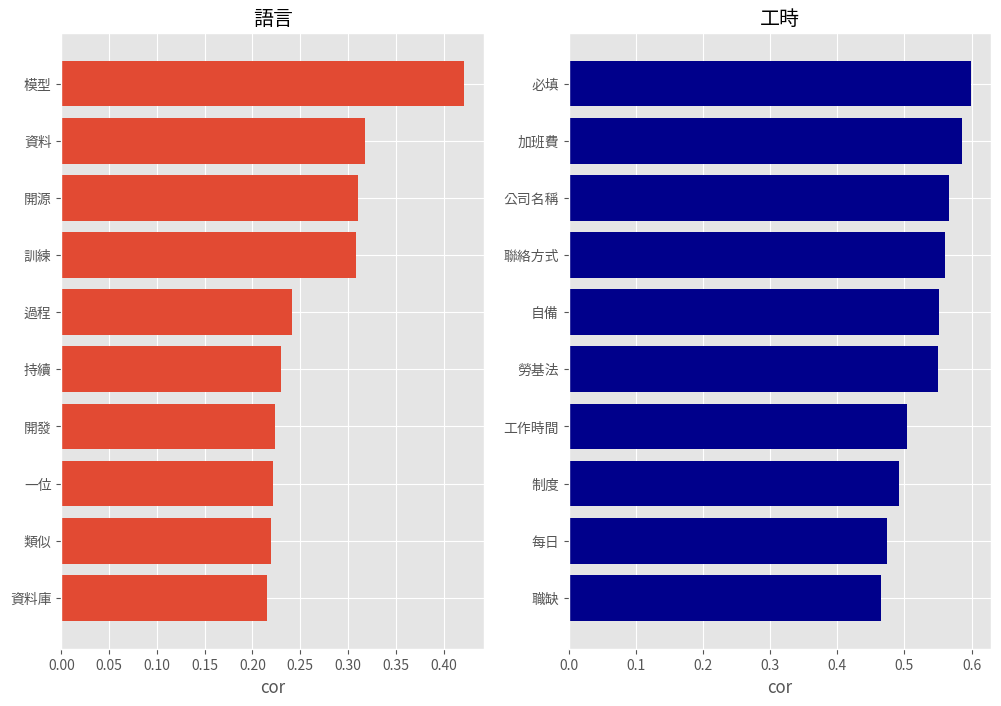

In [101]:
plt.figure(figsize=(12,8))   # 顯示圖框架大小 (寬,高)
plt.style.use("ggplot")     # 使用ggplot主題樣式

plt.subplot(121)
plt.title('語言')
plt.xlabel('cor')
plt.barh(language_sum['word2'],language_sum['cor'])
plt.gca().invert_yaxis()

plt.subplot(122)
plt.title('工時')
plt.xlabel('cor')
plt.barh(workinghours_sum['word2'],workinghours_sum['cor'],color="darkblue")
plt.gca().invert_yaxis()

plt.show()

### ”語言“ 相關詞（技術層面）
* 「語言」相關的詞包括：
模型、訓練、資料、開源等

* 可以發現談論方向的是偏向：
  * AI/機器學習領域的應用，像是大型語言模型、開源訓練資料等
  * 不只是程式語言，也跟深度學習與資料科學高度關聯

### ”工時“ 相關詞（制度與職場文化）
* 「工時」相關的詞包括：
必填、加班費、制度、勞基法

* 可以發現談論方向的是偏向：
  * 公司規章制度、合約條款、招募資訊
  * 經常被拿來探討職場條件與法律保障

### 5.2 使用詞彙關係圖畫出以詞頻前60為節點且相關性高於0.3的組合

In [102]:
# 透過DTM找出詞頻前60高的詞彙
most_freq_df = DTM_df.sum().sort_values(ascending=False).head(60).reset_index().rename(columns={'index':'word', 0:'count'})

most_freq_word = most_freq_df['word'].tolist()

In [103]:
# 保留存在詞頻前60高之詞彙的組合
filtered_df = word_cor_df[(word_cor_df['word1'].isin(most_freq_word)) & (word_cor_df['word2'].isin(most_freq_word))]

# 篩選出相關係數大於0.3的組合
filtered_df = filtered_df[filtered_df['cor'] > 0.3]
filtered_df.reset_index(inplace=True, drop=True)
filtered_df

word1 word2       cor
0      系統    主管  0.328367
1      面試    主管  0.318299
2      團隊    公司  0.354824
3      工作    公司  0.432953
4     工程師    公司  0.304760
..    ...   ...       ...
203    流程    面試  0.317183
204    簡單    面試  0.454456
205    經歷    面試  0.526000
206    經驗    面試  0.553045
207    英文    面試  0.362818

[208 rows x 3 columns]

In [104]:
# Create network plot
g = nx.Graph()

# 建立 nodes 間的連結
for i in range(len(filtered_df)):
    g.add_edge(filtered_df["word1"][i], filtered_df["word2"][i], weight=filtered_df["cor"][i])

# 取得edge權重
weights = [w[2]['weight']*5 for w in  g.edges(data=True)]

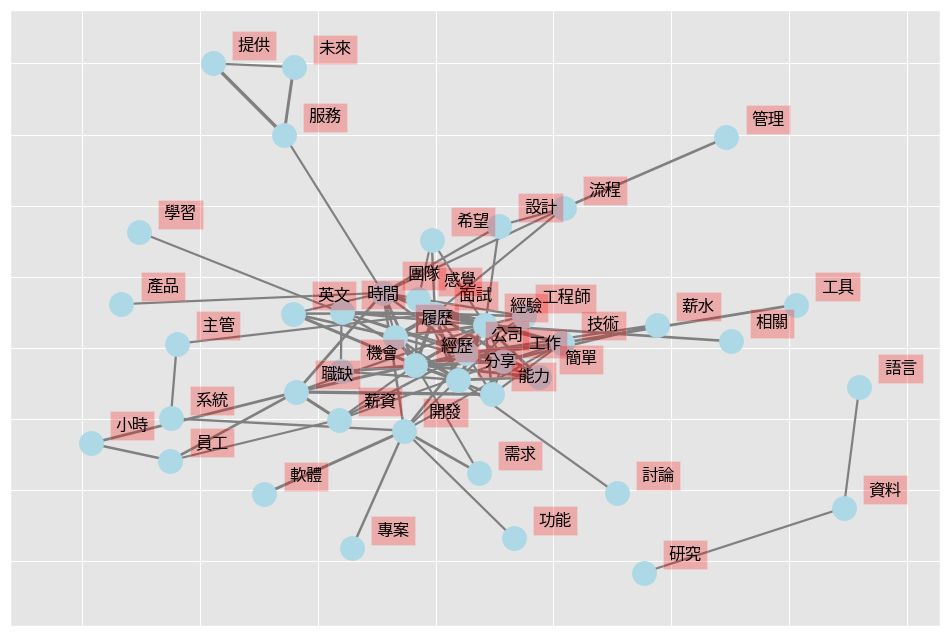

In [105]:
fig, ax = plt.subplots(figsize=(12, 8))

pos = nx.spring_layout(g, k=0.3)

# networks
nx.draw_networkx(g, pos,
                 font_size=16,
                 width=weights,
                 edge_color='grey',
                 node_color='lightblue',
                 with_labels = False,
                 ax=ax)

# 增加 labels
for key, value in pos.items():
    x, y = value[0]+.07, value[1]+.045
    ax.text(x, y,
            s=key,
            bbox=dict(facecolor='red', alpha=0.25),
            horizontalalignment='center', fontsize=12)

plt.show()

從圖中可以清楚看出具有高度相連關係的詞彙。

## 6. 計算文章相似度
以TF-IDF的結果當作文章的向量，計算 Cosine Similarity 找出相似的文章   

In [106]:
data_cos = data_cor.copy()
data_cos.head(3)

system_id                                             artUrl  \
0          1  https://www.ptt.cc/bbs/Soft_Job/M.1672537150.A...   
1          2  https://www.ptt.cc/bbs/Soft_Job/M.1672559293.A...   
2          3  https://www.ptt.cc/bbs/Soft_Job/M.1672571470.A...   

                 artTitle              artDate  \
0  [分享]系統設計:如何取消正在執行的工作任務  2023-01-01 09:39:03   
1      [請益]北漂Offer金融vs假外商  2023-01-01 15:48:11   
2   [請益]有人的公司也沒有提供API文件的嗎  2023-01-01 19:11:08   

                                          artContent  \
0  文字教學:\nhttps://bit.ly/3jFMwvS\n教學影片:\nhttps://...   
1  背景：\n  私立資工學士\n  軟體經驗5Y，後端為主，可以支援前端/CICD\n\n  ...   
2  安安\n\n小弟剛轉前端，進到一家接案公司寫網頁，工作大概9成都在接API，\n但公司內部沒...   

                                            sentence  \
0  文字教學教學影片範例程式系統架構圖本篇來聊聊如何取消正在執行的工作任務當系統內有需要處理比較...   
1  背景私立資工學士軟體經驗後端為主可以支援前端是碩士價廢牡蠣假外商單位產險體系資融金融顧問部分...   
2  安安小弟剛轉前端進到一家接案公司寫網頁工作大概成都在接但公司內部沒有提供規格文件讓我參考導致...   

                                                word  
0  文字 教學 教學 影片 範例 程式 系統 架構圖 本篇 取消 執行 工作 系統 內有 資源 ...  
1  背景 私立 資工 學士 軟體 經驗 支援 前端 碩士 價廢 牡蠣 外商 單位 產險 體系 資...  
2  小弟 剛轉 前端 一家 接案 公司 網頁 工作 成都 公司 內部 提供 規格 文件 參考 導...

In [107]:
transformer = TfidfTransformer()
print(transformer)
# 將詞頻矩陣X統計成TF-IDF值
tfidf = transformer.fit_transform(X)

# 轉成dataframe
TFIDF_df = pd.DataFrame(columns = vocabulary, data = tfidf.toarray())
TFIDF_df

TfidfTransformer()


一位  一個月   一堆        一家        一年   三個        上班   上課   下班        不好  \
0     0.0  0.0  0.0  0.000000  0.000000  0.0  0.000000  0.0  0.0  0.000000   
1     0.0  0.0  0.0  0.000000  0.000000  0.0  0.098792  0.0  0.0  0.000000   
2     0.0  0.0  0.0  0.244478  0.000000  0.0  0.000000  0.0  0.0  0.000000   
3     0.0  0.0  0.0  0.000000  0.000000  0.0  0.000000  0.0  0.0  0.000000   
4     0.0  0.0  0.0  0.000000  0.000000  0.0  0.000000  0.0  0.0  0.000000   
...   ...  ...  ...       ...       ...  ...       ...  ...  ...       ...   
1542  0.0  0.0  0.0  0.000000  0.000000  0.0  0.000000  0.0  0.0  0.000000   
1543  0.0  0.0  0.0  0.000000  0.310894  0.0  0.000000  0.0  0.0  0.334192   
1544  0.0  0.0  0.0  0.000000  0.000000  0.0  0.000000  0.0  0.0  0.000000   
1545  0.0  0.0  0.0  0.000000  0.000000  0.0  0.000000  0.0  0.0  0.000000   
1546  0.0  0.0  0.0  0.021037  0.000000  0.0  0.000000  0.0  0.0  0.000000   

      ...        雲端   電腦        需求        面試  面試官   項目        領域   題目  \
0     ...  0.000000  0.0  0.063611  0.000000  0.0  0.0  0.000000  0.0   
1     ...  0.108983  0.0  0.000000  0.000000  0.0  0.0  0.000000  0.0   
2     ...  0.000000  0.0  0.000000  0.000000  0.0  0.0  0.000000  0.0   
3     ...  0.000000  0.0  0.000000  0.000000  0.0  0.0  0.000000  0.0   
4     ...  0.000000  0.0  0.000000  0.000000  0.0  0.0  0.388807  0.0   
...   ...       ...  ...       ...       ...  ...  ...       ...  ...   
1542  ...  0.000000  0.0  0.000000  0.000000  0.0  0.0  0.000000  0.0   
1543  ...  0.000000  0.0  0.000000  0.230891  0.0  0.0  0.000000  0.0   
1544  ...  0.000000  0.0  0.000000  0.000000  0.0  0.0  0.000000  0.0   
1545  ...  0.000000  0.0  0.000000  0.000000  0.0  0.0  0.000000  0.0   
1546  ...  0.000000  0.0  0.031363  0.000000  0.0  0.0  0.000000  0.0   

            類似   體驗  
0     0.000000  0.0  
1     0.000000  0.0  
2     0.000000  0.0  
3     0.222714  0.0  
4     0.000000  0.0  
...        ...  ...  
1542  0.000000  0.0  
1543  0.000000  0.0  
1544  0.000000  0.0  
1545  0.000000  0.0  
1546  0.000000  0.0  

[1547 rows x 300 columns]

計算文章間的cosine similarity

In [108]:
cosine_matrix = cosine_similarity(tfidf.toarray(), tfidf.toarray())

檢視與第一篇文章相似的文章

In [109]:
cos_df = pd.DataFrame(cosine_matrix[0], columns = ['cos_similarity'])
cos_df

cos_similarity
0           1.000000
1           0.053813
2           0.046821
3           0.012354
4           0.047206
...              ...
1542        0.000000
1543        0.000000
1544        0.077998
1545        0.126623
1546        0.033367

[1547 rows x 1 columns]

In [110]:
cos_df = cos_df.merge(data_cos, how = 'left', left_index=True, right_index=True)
cos_df.loc[:,["cos_similarity", "artTitle", "artUrl"]].sort_values(by=['cos_similarity'], ascending=False).head(10)

cos_similarity                       artTitle  \
0           1.000000         [分享]系統設計:如何取消正在執行的工作任務   
1156        0.569822       Re:[討論]國泰、玉山的IT部門是不是皮皮剉？   
133         0.552698       [心得]自動更新執行中的Docker容器解決方案   
800         0.542625           [討論]Youtube的SLA是幾個9?   
1272        0.450926                    [討論]AWS帳戶被盜   
132         0.440927                  [討論]關於挖角跳槽一事。   
1073        0.428680     [討論].NETFramework跨平台是不是假議題   
796         0.425261  Re:[討論]有可能不學coding就可以取得前後端工作?   
744         0.418454                [新聞]百年郵局全面數位大轉型   
159         0.401656    [心得]用ChatGPT幫忙整理CodeChanges   

                                                 artUrl  
0     https://www.ptt.cc/bbs/Soft_Job/M.1672537150.A...  
1156  https://www.ptt.cc/bbs/Soft_Job/M.1722141381.A...  
133   https://www.ptt.cc/bbs/Soft_Job/M.1677928855.A...  
800   https://www.ptt.cc/bbs/Soft_Job/M.1703210676.A...  
1272  https://www.ptt.cc/bbs/Soft_Job/M.1727630526.A...  
132   https://www.ptt.cc/bbs/Soft_Job/M.1677851305.A...  
1073  https://www.ptt.cc/bbs/Soft_Job/M.1718260802.A...  
796   https://www.ptt.cc/bbs/Soft_Job/M.1703165264.A...  
744   https://www.ptt.cc/bbs/Soft_Job/M.1701558922.A...  
159   https://www.ptt.cc/bbs/Soft_Job/M.1678703464.A...

檢視與第14篇文章相似的文章

In [111]:
cos_df_14 = pd.DataFrame(cosine_matrix[14], columns=['cos_similarity'])

cos_df_14 = cos_df_14.merge(data_cos, how = 'left', left_index=True, right_index=True)
cos_df_14.loc[:,["cos_similarity", "artTitle", "artUrl"]].sort_values(by=['cos_similarity'], ascending=False).head(10)

cos_similarity                        artTitle  \
14          1.000000   [請益]什麼語言是用ppt跟word寫還可以月入100K?   
1134        0.716686                  [請益]請教關於"統一資訊"   
163         0.543876               [請益]請益關於"統一資訊"，謝謝   
629         0.532129  [請益]請問Wireshark如何plotfilter數值?   
272         0.480419                      [請益]技能樹怎麼點   
1544        0.467814             Re:[情報]高雄台南免費程式入門教學   
124         0.456777  [請益]jsthedefinitiveguide3rd價值？   
898         0.454119          Re:[請益]想學程式但數學基礎很差怎麼進步   
1469        0.452112            [請益]純軟研究所中興基資vs北科電子甲   
237         0.449494             [請益]請問資策會地區會有很大差別嗎？   

                                                 artUrl  
14    https://www.ptt.cc/bbs/Soft_Job/M.1673243236.A...  
1134  https://www.ptt.cc/bbs/Soft_Job/M.1721364214.A...  
163   https://www.ptt.cc/bbs/Soft_Job/M.1678755633.A...  
629   https://www.ptt.cc/bbs/Soft_Job/M.1695009578.A...  
272   https://www.ptt.cc/bbs/Soft_Job/M.1681442265.A...  
1544  https://www.ptt.cc/bbs/Soft_Job/M.1743221251.A...  
124   https://www.ptt.cc/bbs/Soft_Job/M.1677476198.A...  
898   https://www.ptt.cc/bbs/Soft_Job/M.1709995806.A...  
1469  https://www.ptt.cc/bbs/Soft_Job/M.1739165453.A...  
237   https://www.ptt.cc/bbs/Soft_Job/M.1680458545.A...

## 7. 補充：建立Ngram預測模型

**使用我們的抓取的 PTT 軟體工程師版資料集**

In [112]:
data3 = MetaData.copy()
sen_tokens = data3.sentence.apply(getToken).tolist()

In [113]:
def ngram(documents, N=2):
    ngram_prediction = dict()
    total_grams = list()
    words = list()
    Word = namedtuple('Word', ['word', 'prob'])

    for doc in documents:
        # 加上開頭和結尾 tag
        split_words = ['<s>'] + list(doc) + ['</s>']
        # 計算分子
        [total_grams.append(tuple(split_words[i:i+N])) for i in range(len(split_words)-N+1)]
        # 計算分母
        [words.append(tuple(split_words[i:i+N-1])) for i in range(len(split_words)-N+2)]

    total_word_counter = Counter(total_grams)
    word_counter = Counter(words)

    for key in total_word_counter:
        word = ''.join(key[:N-1])
        if word not in ngram_prediction:
            ngram_prediction.update({word: set()})

        next_word_prob = total_word_counter[key]/word_counter[key[:N-1]] #P(B|A)
        w = Word(key[-1], '{:.3g}'.format(next_word_prob))
        ngram_prediction[word].add(w)

    return ngram_prediction

In [114]:
# Bigram預測模型為例
bi_prediction = ngram(sen_tokens, N=2)

**預測下一個出現的詞**

In [115]:
text = '喜歡'
next_words = list(bi_prediction[text])
next_words.sort(key = lambda s: s[1], reverse = True)
for next_word in next_words[:5]:
    print('next word: {}, probability: {}'.format(next_word.word, next_word.prob))

next word: 工作, probability: 0.0309
next word: </s>, probability: 0.0247
next word: 加班, probability: 0.0185
next word: 接觸, probability: 0.0185
next word: 鑽研, probability: 0.0123


In [116]:
text = '提供'
next_words = list(bi_prediction[text])
next_words.sort(key = lambda s: s[1], reverse = True)
for next_word in next_words[:5]:
    print('next word: {}, probability: {}'.format(next_word.word, next_word.prob))

next word: 建議, probability: 0.0253
next word: 意見, probability: 0.0253
next word: 服務, probability: 0.0228
next word: 相關, probability: 0.0177
next word: 完整, probability: 0.0152


# **第二組讀書會專案 - 文件分類**
課程：社群媒體分析

授課教授：黃三益老師

組別：Group_2

組員：M124020028,何允中、M134020016,王予芙、M134020034,黃沛萱、M134020037,陳宥齊、B104020032,翁武麟、M124111057,張伶宣


---


資料來源：ptt

版別：打工、軟體工作、科技工作

+ 分析動機：我們想探討不同類型工作的討論重點是否有明顯的差異，特別是軟體工作及科技工作是否存在一定程度的相似性。

+ 分析目標：將三個版別的文章合起來，訓練模型能預測版別，並觀察哪些詞是被模型認為屬於其中一版的

+ 步驟：
    * 載入套件、資料
    * 基本的分類模型流程，包含以下三步驟：
      * 前處理 (preprocess)
      * 建模 (train model)
      * 評估與預測 (evaluation and predict)
    * cross validation
    * 不同分類器的效果
    * 分析可解釋模型的結果

+ 遇到的困難和解決方式

  軟體工作版的資料筆數少於其他兩個版7-8倍，同樣從2024/01/01-2025/03/31的資料，軟體工作只有700+筆，另外兩個版都有5000+，以這樣資料筆數存在極大差異下訓練出來的模型，都很明顯在軟體工作版的預測上比較糟糕，因此我們將時間延長至2020/01/01-2025/03/31，讓三個版別的資料筆數相近，訓練出的模型也更為準確。

In [ ]:
import re
from pprint import pprint

import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import jieba
from sklearn.model_selection import train_test_split, cross_validate, cross_val_predict, KFold
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_curve,
    auc,
    precision_recall_curve,
    RocCurveDisplay
)
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import LabelBinarizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# 設定圖的中文字體
!wget -O TaipeiSansTCBeta-Regular.ttf https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_&export=download

import matplotlib

matplotlib.font_manager.fontManager.addfont('TaipeiSansTCBeta-Regular.ttf')
matplotlib.rc('font', family='Taipei Sans TC Beta')


# 設定圖的中文字體 (無法顯示的話可以試試‘Microsoft JhengHei’字體)
# 也可參考：https://pyecontech.com/2020/03/27/python_matplotlib_chinese/
#plt.rcParams['font.sans-serif'] = ['Noto Sans CJK TC'] #使圖中中文能正常顯示
plt.rcParams['axes.unicode_minus'] = False #使負號能夠顯示

--2025-04-15 07:20:03--  https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_
Resolving drive.google.com (drive.google.com)... 142.250.152.139, 142.250.152.101, 142.250.152.100, ...
Connecting to drive.google.com (drive.google.com)|142.250.152.139|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_ [following]
--2025-04-15 07:20:03--  https://drive.usercontent.google.com/download?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 74.125.202.132, 2607:f8b0:4001:c06::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|74.125.202.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20659344 (20M) [application/octet-stream]
Saving to: ‘TaipeiSansTCBeta-Regular.ttf’

TaipeiSansTCBeta-Re 100%[===================>]  19.70M  --.-KB/s    in 0.1s    

2025-04-15 07

In [ ]:
folder_path = "/content/drive/MyDrive/SMA_2025S-main/"
csv_files = glob.glob(os.path.join(folder_path, '*.csv'))

# 用來存放每一個 DataFrame
df_list = []

# 讀取每個 CSV 並加到 list 裡
for file in csv_files:
    df = pd.read_csv(file)
    df_list.append(df)

# 合併所有 DataFrame
df = pd.concat(df_list, ignore_index=True)

df.head()

system_id                                             artUrl  \
0          1  https://www.ptt.cc/bbs/Tech_Job/M.1704076606.A...   
1          2  https://www.ptt.cc/bbs/Tech_Job/M.1704078788.A...   
2          3  https://www.ptt.cc/bbs/Tech_Job/M.1704080503.A...   
3          4  https://www.ptt.cc/bbs/Tech_Job/M.1704100050.A...   
4          5  https://www.ptt.cc/bbs/Tech_Job/M.1704106015.A...   

                    artTitle              artDate     artPoster artCatagory  \
0        Re:[請益]在新竹上班到底有什麼優點  2024-01-01 10:36:44        dilson    Tech_Job   
1  [新聞]台積電效應！日本半導體廠開2024第1槍　  2024-01-01 11:13:06  qazxc1156892    Tech_Job   
2        Re:[請益]在新竹上班到底有什麼優點  2024-01-01 11:41:41       francej    Tech_Job   
3        Re:[請益]在新竹上班到底有什麼優點  2024-01-01 17:07:27  Onnnnnnnnnnn    Tech_Job   
4     [新聞]「股王製造機」王雪紅不看一時成敗、拚  2024-01-01 18:46:53    GuanLaoBan    Tech_Job   

                                          artContent  \
0  :\n\n不見得喔\n\n我看過私校學店正妹在科技業的男友也是私校學店\n\n因為沒腦的跟有...   
1  新聞標題： 台積電效應！日本半導體廠開2024第1槍　宣告新進員工加薪40%\n\n\n記者...   
2  如果有要生小孩的 新竹大概是目前全國最適合學齡小孩成長的環境吧\n\n人口平均素質高 別的縣...   
3  講新竹太籠統\n\n是新竹市 還是新竹縣 還是以前被割地的竹南？\n\n學區來說\n只要在新...   
4  https://www.nownews.com/news/6331938\n2023年12月...   

                                          artComment            e_ip  \
0  [{"cmtStatus": "推", "cmtPoster": "k11k", "cmtC...    42.79.72.237   
1  [{"cmtStatus": "推", "cmtPoster": "sunnyhung", ...  114.136.154.65   
2  [{"cmtStatus": "→", "cmtPoster": "SpongebobMac...  36.230.152.131   
3  [{"cmtStatus": "推", "cmtPoster": "marsonele", ...   61.230.11.219   
4  [{"cmtStatus": "推", "cmtPoster": "forestsea722...  138.199.22.107   

          insertedDate dataSource  
0  2024-01-02 02:21:08        ptt  
1  2024-01-02 02:21:08        ptt  
2  2024-01-02 02:21:08        ptt  
3  2024-01-02 02:21:08        ptt  
4  2024-01-02 02:21:10        ptt

In [ ]:
# 幾篇文章
print(f"number of posts: {df.shape[0]}")
print(f"date range: {(df['artDate'].min(), df['artDate'].max())}")
print("="*60)

for file in csv_files:
    csv = pd.read_csv(file)
    post_count = csv.shape[0]
    date_range = (csv['artDate'].min(), csv['artDate'].max())

    filename = os.path.basename(file)

    print(f"({filename})")
    print(f"number of posts: {post_count}")
    print(f"date range: {date_range[0]} ~ {date_range[1]}\n")

number of posts: 16332
date range: ('2020-06-01 11:49:04', '2025-03-31 23:33:43')
(ptt_techjob.csv)
number of posts: 5401
date range: 2024-01-01 10:36:44 ~ 2025-03-31 23:33:43

(ptt_parttime.csv)
number of posts: 5570
date range: 2024-01-01 00:25:21 ~ 2025-03-31 22:54:22

(ptt_softjob.csv)
number of posts: 5361
date range: 2020-06-01 11:49:04 ~ 2025-03-31 03:14:57



In [ ]:
# 過濾 nan 的資料
df = df.dropna(subset=['artTitle'])
df = df.dropna(subset=['artContent'])
# 移除網址格式
df["artContent"] = df.artContent.apply(
    lambda x: re.sub("(http|https)://.*", "", x)
)
df["artTitle"] = df["artTitle"].apply(
    lambda x: re.sub("(http|https)://.*", "", x)
)
# 只留下中文字
df["artContent"] = df.artContent.apply(
    lambda x: re.sub("[^\u4e00-\u9fa5]+", "", x)
)
df["artTitle"] = df["artTitle"].apply(
    lambda x: re.sub("[^\u4e00-\u9fa5]+", "", x)
)
df.head(3)

<ipython-input-7-62c67f3139c0>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["artContent"] = df.artContent.apply(
<ipython-input-7-62c67f3139c0>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["artTitle"] = df["artTitle"].apply(


system_id                                             artUrl  \
0          1  https://www.ptt.cc/bbs/Tech_Job/M.1704076606.A...   
1          2  https://www.ptt.cc/bbs/Tech_Job/M.1704078788.A...   
2          3  https://www.ptt.cc/bbs/Tech_Job/M.1704080503.A...   

           artTitle              artDate     artPoster artCatagory  \
0    請益在新竹上班到底有什麼優點  2024-01-01 10:36:44        dilson    Tech_Job   
1  新聞台積電效應日本半導體廠開第槍  2024-01-01 11:13:06  qazxc1156892    Tech_Job   
2    請益在新竹上班到底有什麼優點  2024-01-01 11:41:41       francej    Tech_Job   

                                          artContent  \
0  不見得喔我看過私校學店正妹在科技業的男友也是私校學店因為沒腦的跟有腦的怎麼可能有話聊台清交電...   
1  新聞標題台積電效應日本半導體廠開第槍宣告新進員工加薪記者陳瑩欣台北報導台積電等大型半導體廠赴...   
2  如果有要生小孩的新竹大概是目前全國最適合學齡小孩成長的環境吧人口平均素質高別的縣市包括雙北擔...   

                                          artComment            e_ip  \
0  [{"cmtStatus": "推", "cmtPoster": "k11k", "cmtC...    42.79.72.237   
1  [{"cmtStatus": "推", "cmtPoster": "sunnyhung", ...  114.136.154.65   
2  [{"cmtStatus": "→", "cmtPoster": "SpongebobMac...  36.230.152.131   

          insertedDate dataSource  
0  2024-01-02 02:21:08        ptt  
1  2024-01-02 02:21:08        ptt  
2  2024-01-02 02:21:08        ptt

In [ ]:
# 留下 content
df["content"] = df["artTitle"] + df["artContent"]
df = df[["content", "artUrl", "artCatagory"]]  # 文章內容 文章連結
df.head()

content  \
0  請益在新竹上班到底有什麼優點不見得喔我看過私校學店正妹在科技業的男友也是私校學店因為沒腦的跟...   
1  新聞台積電效應日本半導體廠開第槍新聞標題台積電效應日本半導體廠開第槍宣告新進員工加薪記者陳瑩...   
2  請益在新竹上班到底有什麼優點如果有要生小孩的新竹大概是目前全國最適合學齡小孩成長的環境吧人口...   
3  請益在新竹上班到底有什麼優點講新竹太籠統是新竹市還是新竹縣還是以前被割地的竹南學區來說只要在...   
4  新聞股王製造機王雪紅不看一時成敗拚年月日記者許家禎特稿股王製造機王雪紅不看一時成敗拚氣長宏達...   

                                              artUrl artCatagory  
0  https://www.ptt.cc/bbs/Tech_Job/M.1704076606.A...    Tech_Job  
1  https://www.ptt.cc/bbs/Tech_Job/M.1704078788.A...    Tech_Job  
2  https://www.ptt.cc/bbs/Tech_Job/M.1704080503.A...    Tech_Job  
3  https://www.ptt.cc/bbs/Tech_Job/M.1704100050.A...    Tech_Job  
4  https://www.ptt.cc/bbs/Tech_Job/M.1704106015.A...    Tech_Job

In [ ]:
print(f"total docs: {df.shape[0]}")

total docs: 16310


# **斷詞**

In [ ]:
# 設定繁體中文詞庫
jieba.set_dictionary("/content/drive/MyDrive/SMA_2025S-main/week07/dict/dict.txt.big")

# 新增stopwords
# jieba.analyse.set_stop_words('./dict/stop_words.txt') #jieba.analyse.extract_tags才會作用
with open("/content/drive/MyDrive/SMA_2025S-main/week07/dict/stop_words.txt", encoding="utf-8") as f:
    stopWords = [line.strip() for line in f.readlines()]

In [ ]:
# 設定斷詞 function
def getToken(row):
    seg_list = jieba.cut(row, cut_all=False)
    seg_list = [
        w for w in seg_list if w not in stopWords and len(w) > 1
    ]  # 篩選掉停用字與字元數大於1的詞彙
    return seg_list

df["words"] = df["content"].apply(getToken).map(" ".join)
df.head()

Building prefix dict from /content/drive/MyDrive/SMA_2025S-main/week07/dict/dict.txt.big ...
DEBUG:jieba:Building prefix dict from /content/drive/MyDrive/SMA_2025S-main/week07/dict/dict.txt.big ...
Dumping model to file cache /tmp/jieba.u7fdbfa156d71dde3366dc327b32adc37.cache
DEBUG:jieba:Dumping model to file cache /tmp/jieba.u7fdbfa156d71dde3366dc327b32adc37.cache
Loading model cost 5.069 seconds.
DEBUG:jieba:Loading model cost 5.069 seconds.
Prefix dict has been built successfully.
DEBUG:jieba:Prefix dict has been built successfully.


content  \
0  請益在新竹上班到底有什麼優點不見得喔我看過私校學店正妹在科技業的男友也是私校學店因為沒腦的跟...   
1  新聞台積電效應日本半導體廠開第槍新聞標題台積電效應日本半導體廠開第槍宣告新進員工加薪記者陳瑩...   
2  請益在新竹上班到底有什麼優點如果有要生小孩的新竹大概是目前全國最適合學齡小孩成長的環境吧人口...   
3  請益在新竹上班到底有什麼優點講新竹太籠統是新竹市還是新竹縣還是以前被割地的竹南學區來說只要在...   
4  新聞股王製造機王雪紅不看一時成敗拚年月日記者許家禎特稿股王製造機王雪紅不看一時成敗拚氣長宏達...   

                                              artUrl artCatagory  \
0  https://www.ptt.cc/bbs/Tech_Job/M.1704076606.A...    Tech_Job   
1  https://www.ptt.cc/bbs/Tech_Job/M.1704078788.A...    Tech_Job   
2  https://www.ptt.cc/bbs/Tech_Job/M.1704080503.A...    Tech_Job   
3  https://www.ptt.cc/bbs/Tech_Job/M.1704100050.A...    Tech_Job   
4  https://www.ptt.cc/bbs/Tech_Job/M.1704106015.A...    Tech_Job   

                                               words  
0  請益 新竹 上班 優點 不見得 看過 私校 學店 正妹 科技 業的 男友 私校 學店 沒腦 ...  
1  新聞 台積電 效應 日本 半導體 廠開 第槍 新聞標題 台積電 效應 日本 半導體 廠開 第...  
2  請益 新竹 上班 優點 有要 生小孩 新竹 目前 全國 適合 學齡 小孩 成長 環境 人口 ...  
3  請益 新竹 上班 優點 新竹 籠統 新竹市 新竹縣 以前 割地 竹南 學區 來說 新竹市 東...  
4  新聞 股王 製造機 王雪紅 一時 成敗 年月日 記者 許家 特稿 股王 製造機 王雪紅 一時...

# **訓練**

In [ ]:
# 檢視資料
print(f"total posts: {len(df['artUrl'].unique())}")
print(f"category: \n{df['artCatagory'].value_counts()}")
print("="*100)

data = df
X = data["words"]
y = data["artCatagory"]

# 把整個資料集七三切
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=777
)

print(X_train.head())
print(y_train.head())

total posts: 16310
category: 
artCatagory
part_time    5567
Tech_Job     5395
Soft_Job     5348
Name: count, dtype: int64
11414    請益 大學 休學 全心 工作 覺得 聰明 讀書 兼顧 帶來 回報 讀書 自然 選擇 輟學 天...
7721     新北 新店 裕隆 活動 派票 時薪 同意 願意 遵守 現行 法律 本站 使用者 條款 本站 ...
3256     新聞 中國 實現 國產 曝光 機可 生產 奈米 中國 實現 國產 曝光 機可 生產 奈米 以...
15141    徵才 遠端 美商 公司 名稱 統編 中華民國 以外 註冊 可免 公司地址 填寫 詳細 至號 ...
13980    問卷 藍牙 耳機 進修 網之 職涯 進修 調查 人力 銀行 今年 針對 上班族 進修 調查 ...
Name: words, dtype: object
11414     Soft_Job
7721     part_time
3256      Tech_Job
15141     Soft_Job
13980     Soft_Job
Name: artCatagory, dtype: object


In [ ]:
# 看一下各個資料集切分的比例，應該要一致
print(
    f"raw data percentage :\n{data['artCatagory'].value_counts(normalize=True) * 100}"
)
print(f"\ntrain percentage :\n{y_train.value_counts(normalize=True) * 100}")
print(f"\ntest percentage :\n{y_test.value_counts(normalize=True) * 100}")

raw data percentage :
artCatagory
part_time    34.132434
Tech_Job     33.077866
Soft_Job     32.789700
Name: proportion, dtype: float64

train percentage :
artCatagory
part_time    34.229658
Tech_Job     33.432601
Soft_Job     32.337742
Name: proportion, dtype: float64

test percentage :
artCatagory
part_time    33.905579
Soft_Job     33.844267
Tech_Job     32.250153
Name: proportion, dtype: float64


# **DTM**

In [ ]:
vectorizer = CountVectorizer(max_features=1000)
X_train.head()

11414    請益 大學 休學 全心 工作 覺得 聰明 讀書 兼顧 帶來 回報 讀書 自然 選擇 輟學 天...
7721     新北 新店 裕隆 活動 派票 時薪 同意 願意 遵守 現行 法律 本站 使用者 條款 本站 ...
3256     新聞 中國 實現 國產 曝光 機可 生產 奈米 中國 實現 國產 曝光 機可 生產 奈米 以...
15141    徵才 遠端 美商 公司 名稱 統編 中華民國 以外 註冊 可免 公司地址 填寫 詳細 至號 ...
13980    問卷 藍牙 耳機 進修 網之 職涯 進修 調查 人力 銀行 今年 針對 上班族 進修 調查 ...
Name: words, dtype: object

In [ ]:
vec_train = vectorizer.fit_transform(X_train)
vocabulary = vectorizer.get_feature_names_out()

Count_df = pd.DataFrame(columns = vocabulary, data = vec_train.toarray())
Count_df

一下  一些  一任  一份  一位  一個月  一堆  一天  一定  一家  ...  願意  類似  類別  顧問  顯示  風險  \
0       0   0   0   0   0    0   0   0   0   0  ...   0   0   0   0   0   0   
1       0   0   0   0   0    0   0   0   0   0  ...   2   0   0   0   0   0   
2       0   0   0   0   0    0   0   0   0   0  ...   0   0   0   0   2   0   
3       0   1   0   0   0    0   0   0   0   0  ...   0   0   0   0   0   0   
4       0   0   0   0   0    0   0   0   0   0  ...   0   0   0   0   0   0   
...    ..  ..  ..  ..  ..  ...  ..  ..  ..  ..  ...  ..  ..  ..  ..  ..  ..   
11412   0   0   1   0   0    0   0   0   0   0  ...   2   0   1   1   1   1   
11413   0   0   0   0   0    0   0   0   0   0  ...   0   0   0   0   0   0   
11414   0   0   0   0   0    0   0   0   0   0  ...   0   0   0   0   0   0   
11415   0   0   0   0   0    0   0   0   0   1  ...   0   0   0   0   0   0   
11416   0   0   0   0   0    0   0   0   0   0  ...   0   0   0   0   0   0   

       餐廳  馬斯克  體驗  高雄  
0       0    0   0   0  
1       0    0   0   0  
2       0    0   0   0  
3       0    0   0   0  
4       0    0   0   0  
...    ..  ...  ..  ..  
11412   1    0   0   0  
11413   0    0   0   0  
11414   0    0   0   0  
11415   0    0   0   0  
11416   0    0   0   0  

[11417 rows x 1000 columns]

In [ ]:
vec_test = vectorizer.transform(X_test)
print(vec_train.shape)
print(vec_test.shape)

(11417, 1000)
(4893, 1000)


# **邏輯式回歸分類器**

In [ ]:
# 建立分類器模型
clf = LogisticRegression()
clf.fit(vec_train, y_train)
clf

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [ ]:
clf.classes_

array(['Soft_Job', 'Tech_Job', 'part_time'], dtype=object)

**使用train set訓練完後，用測試集試試看模型的分類結果**

In [ ]:
y_pred = clf.predict(vec_test)
y_pred_proba = clf.predict_proba(vec_test)
print(y_pred[:10])

print(y_pred_proba.shape)
y_pred_proba[0,:]

['part_time' 'part_time' 'Tech_Job' 'part_time' 'Soft_Job' 'Soft_Job'
 'Soft_Job' 'part_time' 'Tech_Job' 'Tech_Job']
(4893, 3)


array([7.48678735e-23, 1.11943780e-22, 1.00000000e+00])

# **模型評估**

In [ ]:
## Accuracy, Precision, Recall, F1-score
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    Soft_Job       0.87      0.85      0.86      1656
    Tech_Job       0.85      0.87      0.86      1578
   part_time       1.00      1.00      1.00      1659

    accuracy                           0.91      4893
   macro avg       0.91      0.91      0.91      4893
weighted avg       0.91      0.91      0.91      4893



**Confusion Matrix**

(array([0.5, 1.5, 2.5]),
 [Text(0, 0.5, 'Soft_Job'),
  Text(0, 1.5, 'Tech_Job'),
  Text(0, 2.5, 'part_time')])

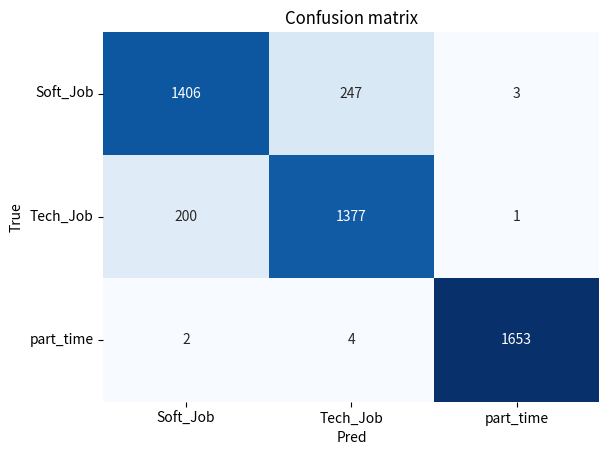

In [ ]:
classes = clf.classes_
cm = confusion_matrix(y_test, y_pred)
cm

## Plot confusion matrix
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt="d", ax=ax, cmap=plt.cm.Blues, cbar=False)
ax.set(
    xlabel="Pred",
    ylabel="True",
    xticklabels=classes,
    yticklabels=classes,
    title="Confusion matrix",
)
plt.yticks(rotation=0)

# **TF-IDF DTM**

In [ ]:
vectorizer = TfidfVectorizer(max_features=1000)
vec_train = vectorizer.fit_transform(X_train)
vec_test = vectorizer.transform(X_test)
vocabulary = vectorizer.get_feature_names_out()

tfidf_df = pd.DataFrame(columns = vocabulary, data = vec_train.toarray())
tfidf_df

一下        一些        一任   一份   一位  一個月   一堆   一天   一定        一家  ...  \
0      0.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  ...   
1      0.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  ...   
2      0.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  ...   
3      0.0  0.046436  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  ...   
4      0.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  ...   
...    ...       ...       ...  ...  ...  ...  ...  ...  ...       ...  ...   
11412  0.0  0.000000  0.025203  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  ...   
11413  0.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  ...   
11414  0.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  ...   
11415  0.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.271224  ...   
11416  0.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  ...   

             願意   類似        類別        顧問        顯示        風險        餐廳  馬斯克  \
0      0.000000  0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.0   
1      0.125851  0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.0   
2      0.000000  0.0  0.000000  0.000000  0.064781  0.000000  0.000000  0.0   
3      0.000000  0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.0   
4      0.000000  0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.0   
...         ...  ...       ...       ...       ...       ...       ...  ...   
11412  0.038270  0.0  0.024139  0.043534  0.023576  0.023945  0.024656  0.0   
11413  0.000000  0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.0   
11414  0.000000  0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.0   
11415  0.000000  0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.0   
11416  0.000000  0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.0   

        體驗   高雄  
0      0.0  0.0  
1      0.0  0.0  
2      0.0  0.0  
3      0.0  0.0  
4      0.0  0.0  
...    ...  ...  
11412  0.0  0.0  
11413  0.0  0.0  
11414  0.0  0.0  
11415  0.0  0.0  
11416  0.0  0.0  

[11417 rows x 1000 columns]

In [ ]:
clf.fit(vec_train, y_train)
y_pred = clf.predict(vec_test)
y_pred_proba = clf.predict_proba(vec_test)

# results
## Accuracy, Precision, Recall, F1-score
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    Soft_Job       0.89      0.89      0.89      1656
    Tech_Job       0.88      0.88      0.88      1578
   part_time       1.00      0.99      1.00      1659

    accuracy                           0.92      4893
   macro avg       0.92      0.92      0.92      4893
weighted avg       0.92      0.92      0.92      4893



# 比較

明顯看出軟體及科技工作的預測相對於打工更易使模型混淆，表示兩者在被討論時有著重疊的用詞


**依據詞頻**

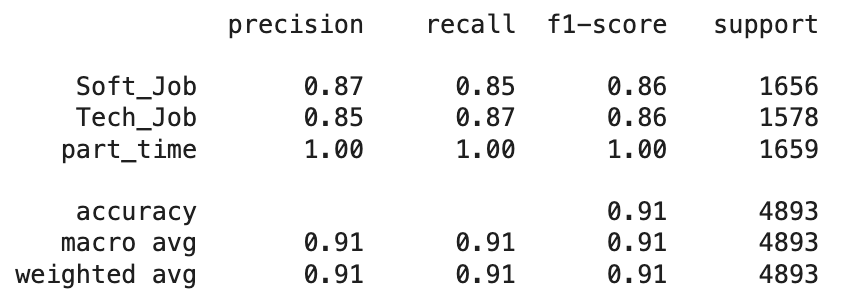


**依據TF-IDF**

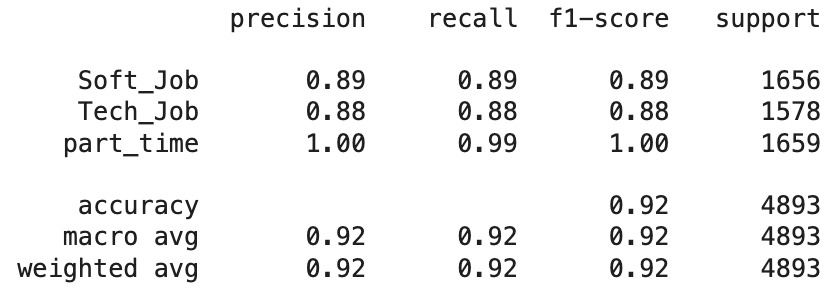


# **CV cross-validation**
切成 k 組 train-test dataset

In [ ]:
clf = LogisticRegression()
vec_train = TfidfVectorizer(max_features=1000).fit_transform(X_train)

scores = cross_validate(clf, vec_train, y_train, cv=5, scoring=("f1_macro", "recall_macro", "precision_macro"), return_estimator=True)
pprint(scores)

{'estimator': [LogisticRegression(),
               LogisticRegression(),
               LogisticRegression(),
               LogisticRegression(),
               LogisticRegression()],
 'fit_time': array([0.23089862, 0.27636576, 0.25236869, 0.34397149, 0.27416658]),
 'score_time': array([0.02289605, 0.024647  , 0.02181077, 0.0233047 , 0.0221231 ]),
 'test_f1_macro': array([0.91902789, 0.9123334 , 0.91506679, 0.91453077, 0.90227382]),
 'test_precision_macro': array([0.91950184, 0.91240797, 0.91527236, 0.91474791, 0.90267443]),
 'test_recall_macro': array([0.9191661 , 0.91231691, 0.91495399, 0.91452967, 0.90217693])}


In [ ]:
y_pred = cross_val_predict(clf, vec_train, y_train, cv=5)
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

    Soft_Job       0.86      0.88      0.87      3692
    Tech_Job       0.88      0.86      0.87      3817
   part_time       1.00      0.99      0.99      3908

    accuracy                           0.91     11417
   macro avg       0.91      0.91      0.91     11417
weighted avg       0.91      0.91      0.91     11417



# **比較不同模型**

In [ ]:
# 定義模型訓練組合
## pipeline: 資料處理 vectorizer + 分類器 clf
## 由於 cross-validation 會自動將資料分成 train/test，因此 input 只要給 X, y 即可

def train_cv(vectorizer, clf, X, y):

    ## train classifier
    vec_X = vectorizer.fit_transform(X).toarray()

    ## get cv results
    cv_results = cross_validate(clf, vec_X, y, cv=5, return_estimator=True)
    y_pred = cross_val_predict(clf, vec_X, y, cv=5)
    y_pred_proba = cross_val_predict(clf, vec_X, y, cv=5, method="predict_proba")

    ## Accuracy, Precision, Recall, F1-score
    cls_report = classification_report(y, y_pred, output_dict=True)
    print(classification_report(y, y_pred))

    classes = cv_results['estimator'][0].classes_

    ## Plot confusion matrix
    cm = confusion_matrix(y, y_pred)
    fig, ax = plt.subplots()
    sns.heatmap(cm, annot=True, fmt="d", ax=ax, cmap=plt.cm.Blues, cbar=False)
    ax.set(
        xlabel="Pred",
        ylabel="True",
        xticklabels=classes,
        yticklabels=classes,
        title= str(clf) + "Confusion matrix",
    )
    plt.yticks(rotation=0)

    clf.fit(vec_X, y)
    # return the model object
    return cls_report

              precision    recall  f1-score   support

    Soft_Job       0.86      0.88      0.87      3692
    Tech_Job       0.88      0.86      0.87      3817
   part_time       1.00      0.99      0.99      3908

    accuracy                           0.91     11417
   macro avg       0.91      0.91      0.91     11417
weighted avg       0.91      0.91      0.91     11417



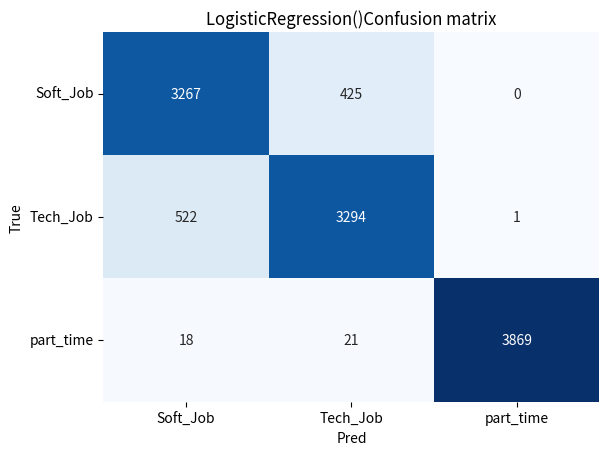

In [ ]:
vectorizer = TfidfVectorizer(max_features=1000)
clf = LogisticRegression()
result = train_cv(vectorizer, clf, X_train, y_train)

now training: clf_logistic
              precision    recall  f1-score   support

    Soft_Job       0.86      0.88      0.87      3692
    Tech_Job       0.88      0.86      0.87      3817
   part_time       1.00      0.99      0.99      3908

    accuracy                           0.91     11417
   macro avg       0.91      0.91      0.91     11417
weighted avg       0.91      0.91      0.91     11417

now training: clf_dtree
              precision    recall  f1-score   support

    Soft_Job       0.79      0.80      0.80      3692
    Tech_Job       0.80      0.80      0.80      3817
   part_time       0.99      0.99      0.99      3908

    accuracy                           0.86     11417
   macro avg       0.86      0.86      0.86     11417
weighted avg       0.86      0.86      0.86     11417

now training: clf_svm
              precision    recall  f1-score   support

    Soft_Job       0.85      0.90      0.87      3692
    Tech_Job       0.89      0.86      0.87      3817
  

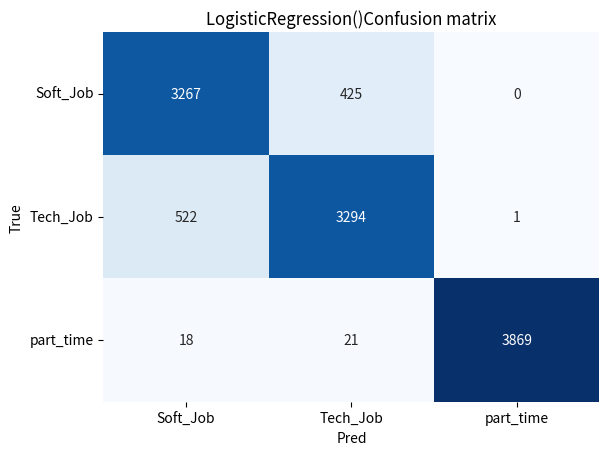

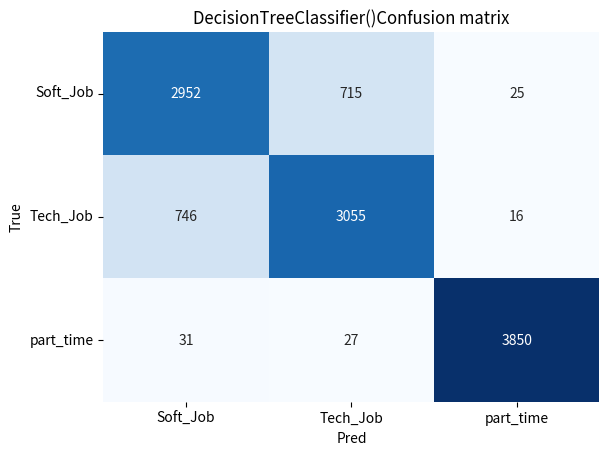

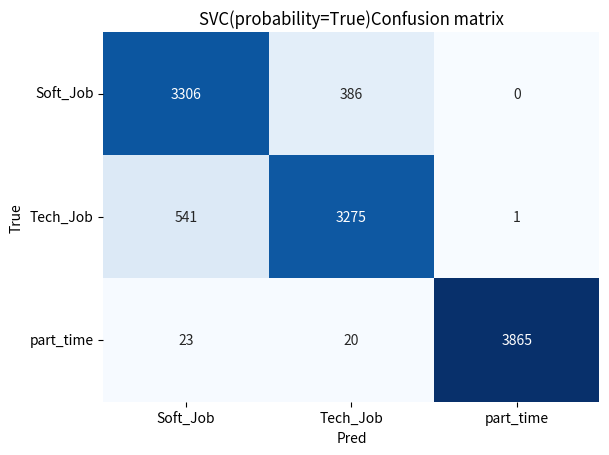

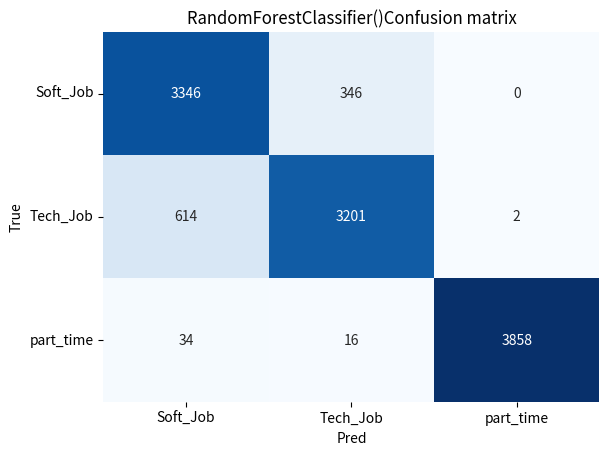

In [ ]:
# 準備訓練資料
X = data["words"]
y = data["artCatagory"]

# 把整個資料集七三切
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=777
)
# 定義模型訓練組合
model_set = dict()
model_set['clf_logistic'] = LogisticRegression()
model_set['clf_dtree'] = DecisionTreeClassifier()
model_set['clf_svm'] = svm.SVC(probability=True) # 要使用SVM的predict_proba的話，必須在叫出SVC的時候就將probability設為True
model_set['clf_rf'] = RandomForestClassifier()
# 定義 vectorizer
# vectorizer = CountVectorizer(max_features=1000)
vectorizer = TfidfVectorizer(max_features=1000)
# 存結果
result_set = dict()

for k, model in model_set.items():
    print("="*100)
    print(f"now training: {k}")
    result_set[k] = train_cv(vectorizer, model, X_train, y_train)
    print("="*100)

**分別觀察各個分類模型在不同類別的評估指標表現如何**

In [ ]:
result_set['clf_logistic']

{'Soft_Job': {'precision': 0.8581560283687943,
  'recall': 0.8848862405200434,
  'f1-score': 0.8713161754900653,
  'support': 3692.0},
 'Tech_Job': {'precision': 0.8807486631016043,
  'recall': 0.8629813990044538,
  'f1-score': 0.8717745136959111,
  'support': 3817.0},
 'part_time': {'precision': 0.9997416020671834,
  'recall': 0.9900204708290685,
  'f1-score': 0.9948572897917203,
  'support': 3908.0},
 'accuracy': 0.9135499693439607,
 'macro avg': {'precision': 0.9128820978458606,
  'recall': 0.9126293701178553,
  'f1-score': 0.9126493263258988,
  'support': 11417.0},
 'weighted avg': {'precision': 0.9141735906696125,
  'recall': 0.9135499693439607,
  'f1-score': 0.9137571102034384,
  'support': 11417.0}}

**找出f1-score表現最好的模型是哪個，作為我們最終得到的分類器**

In [ ]:
max = 0
best_model_name = ""
best_model_metric = "f1-score"

## choose max f1-score model from result_set
for k, v in result_set.items():
    if v['weighted avg'][best_model_metric] > max:
        max = v['weighted avg'][best_model_metric]
        best_model_name = k
print(f"best model: {best_model_name}")
pprint(result_set[best_model_name])

best model: clf_svm
{'Soft_Job': {'f1-score': 0.8743718592964824,
              'precision': 0.8542635658914729,
              'recall': 0.8954496208017335,
              'support': 3692.0},
 'Tech_Job': {'f1-score': 0.8735662843424913,
              'precision': 0.8897038848139093,
              'recall': 0.8580036678019387,
              'support': 3817.0},
 'accuracy': 0.9149513882806342,
 'macro avg': {'f1-score': 0.9140927505638188,
               'precision': 0.9145695951394212,
               'recall': 0.9141500726597706,
               'support': 11417.0},
 'part_time': {'f1-score': 0.9943401080524826,
               'precision': 0.9997413347128815,
               'recall': 0.9889969293756398,
               'support': 3908.0},
 'weighted avg': {'f1-score': 0.9151672553321366,
                  'precision': 0.9159087281828808,
                  'recall': 0.9149513882806342,
                  'support': 11417.0}}


# **各字詞特徵的迴歸係數**

+ 迴歸係數（coefficient estimates）反映了每個特徵對預測結果的影響程度和方向。​當其他變數保持不變時，某一特徵的值增加一個單位（例如詞頻增加1），其對應的迴歸係數表示該特徵對事件發生機率的影響。
+ 計算後得到勝算比（odds ratio），這表示該特徵每增加一個單位，事件發生的勝算（odds）相對於未增加時的倍數變化。
+ 這裡舉logistic regression + cv tokenizer 為例

In [ ]:
def plot_coef(logistic_reg_model, feature_names, top_n=10):
    # 選出某個類別的前10大影響力字詞
    log_odds = logistic_reg_model.coef_.T
    coef_df = pd.DataFrame(
        log_odds,
        columns=logistic_reg_model.classes_, index=feature_names
    )
    for label in coef_df.columns:
        select_words = (
            coef_df[[label]]
            .sort_values(by=label, ascending=False)
            .iloc[np.r_[0:top_n, -top_n:0]]
        )
        word = select_words.index
        count = select_words[label]
        category_colors = np.where(
            select_words[label] >= 0, "darkseagreen", "rosybrown"
        )  # 設定顏色

        fig, ax = plt.subplots(figsize=(8, top_n*0.8))  # 設定畫布
        plt.rcParams["axes.unicode_minus"] = False

        ax.barh(word, count, color=category_colors)
        ax.invert_yaxis()
        ax.set_title(
            "Coeff increase/decrease odds ratio of 「" + label + "」 label the most",
            loc="left",
            size=16,
        )
        ax.set_ylabel("word", size=14)
        ax.set_xlabel("odds ratio", size=14)

# **第二組讀書會專案 - 文件分類**
課程：社群媒體分析

授課教授：黃三益老師

組別：Group_2

組員：M124020028,何允中、M134020016,王予芙、M134020034,黃沛萱、M134020037,陳宥齊、B104020032,翁武麟、M124111057,張伶宣


---


資料來源：ptt

版別：打工、軟體工作、科技工作

資料筆數：16310

+ 分析動機：我們想探討不同類型工作的討論重點是否有明顯的差異，特別是軟體工作及科技工作是否存在一定程度的相似性。

+ 分析目標：將三個版別的文章合起來，訓練模型能預測潛在主題

+ 步驟：
  1. 資料前處理 
  2. lexicon-based 的主題模型
  3. LDA 主題模型 
      - 整理 dictionary 和corpus
      - 訓練LDA topic model
      - 透過LDA模型指標尋找最佳主題數
      - 視覺化呈現分析結果
  4. GuidedLDA

+ 遇到的困難和解決方式:
  - 發現打工版的文章都含有一些相同的警告標語，影響到了後續的分類準確性，將警告標語移除
  - 時間跨度上，軟體版的分布較長，會影響分析時的聚焦性:分析時僅看2024之後的


In [ ]:
import time 
from functools import reduce
from collections import Counter
from pprint import pprint

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import jieba
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from gensim.corpora import Dictionary
from gensim.models import LdaModel, CoherenceModel
from gensim.models.ldamulticore import LdaMulticore
from gensim.matutils import corpus2csc, corpus2dense, Sparse2Corpus

import pyLDAvis
import pyLDAvis.gensim_models

In [ ]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

# 1. 資料前處理

In [ ]:
parttime = pd.read_csv("raw_data/ptt_parttime.csv")  # 匯資料
softjob = pd.read_csv("raw_data/ptt_softjob.csv")
techjob = pd.read_csv("raw_data/ptt_techjob.csv")
data = pd.concat([parttime,softjob,techjob])
data.head(3)

system_id                                             artUrl  \
0          1  https://www.ptt.cc/bbs/part-time/M.1704039923....   
1          2  https://www.ptt.cc/bbs/part-time/M.1704068173....   
2          3  https://www.ptt.cc/bbs/part-time/M.1704077270....   

                artTitle              artDate  artPoster artCatagory  \
0        [個人]桃園搬家助手1/1兩位  2024-01-01 00:25:21     snk236   part_time   
1  [台北/市調]維他命座談會車馬費1500元  2024-01-01 08:16:11  Portmento   part_time   
2           [多區/個人]PPT製作  2024-01-01 10:47:48    bonzi42   part_time   

                                          artContent  \
0  本人同意並願意遵守現行法律、本站使用者條款、本站各級規定、本板所有規範，\n本人願意為本文內...   
1  本人同意並願意遵守現行法律、本站使用者條款、本站各級規定、本板所有規範，\n本人願意為本文內...   
2  本人同意並願意遵守現行法律、本站使用者條款、本站各級規定、本板所有規範，\n本人願意為本文內...   

                                          artComment             e_ip  \
0                                                 []    114.136.39.28   
1  [{"cmtStatus": "噓", "cmtPoster": "GUANGLEI", "...   125.229.192.37   
2                                                 []  118.165.136.221   

          insertedDate dataSource  
0  2024-01-01 02:09:00        ptt  
1  2024-01-02 02:11:21        ptt  
2  2024-01-02 02:11:21        ptt

In [ ]:
# 移除警告標語
warns = ["本人同意並願意遵守現行法律、本站使用者條款、本站各級規定、本板所有規範",
         "本人願意為本文內容負責，並保証本文內容皆詳盡屬實，若違反相關規範，願受處分",
         "誤刪者應至本板使用規範第37條或z-53-3複製範本",
         "提醒：上方二行文字不得刪除或變更",
         "違者文章逕行刪除",
         "本行提醒得Ctrl+Y刪除之",
         "誤刪者應至本板使用規範第37條或z-53-3複製範本",
         "為必填項目，缺項應保留空項目名稱，灰色文字得刪除之",
         "各項均不得為「面議」",
         "本文僅授權發表於PTT實業坊",
         "未經同意不得轉載至其它網站",
         "本人保留一切訴訟權",
         "否則得視情況提出告訴",
         "承攬制等不適用排班、休息之工作者僅填第一項「交件期」，其餘項留空白",
         "一次性工作且未滿四小時者，得將全部資訊填於第一項，其餘項留空白",
         "不定期工作，第一項「工作期」應填「長期」及可開始工作日",
         "第二項「排班方式」應填每週或每月何日出勤(休息)，或現場排班等，一次性工作留空",
         "第三、四項「工作時間」「休息時間」得合併至第三項，第四項留空白",
         "第四項「休息時間」、第五項「休息計薪供餐」依實際情形填寫之(第五項擇一)",
         "任一項僅寫「面議」或同義文字者，一律水桶一年並退文"]


for warn in warns:
    data["artContent"] = data["artContent"].str.replace(warn, "")
data.head(10)

system_id                                             artUrl  \
0          1  https://www.ptt.cc/bbs/part-time/M.1704039923....   
1          2  https://www.ptt.cc/bbs/part-time/M.1704068173....   
2          3  https://www.ptt.cc/bbs/part-time/M.1704077270....   
3          4  https://www.ptt.cc/bbs/part-time/M.1704078649....   
4          5  https://www.ptt.cc/bbs/part-time/M.1704084465....   
5          6  https://www.ptt.cc/bbs/part-time/M.1704085782....   
6          7  https://www.ptt.cc/bbs/part-time/M.1704097191....   
7          8  https://www.ptt.cc/bbs/part-time/M.1704101881....   
8          9  https://www.ptt.cc/bbs/part-time/M.1704115238....   
9         10  https://www.ptt.cc/bbs/part-time/M.1704116155....   

                     artTitle              artDate   artPoster artCatagory  \
0             [個人]桃園搬家助手1/1兩位  2024-01-01 00:25:21      snk236   part_time   
1       [台北/市調]維他命座談會車馬費1500元  2024-01-01 08:16:11   Portmento   part_time   
2                [多區/個人]PPT製作  2024-01-01 10:47:48     bonzi42   part_time   
3             [多區/個人]網頁Logo設計  2024-01-01 11:10:47   ymd124783   part_time   
4       [個人]西語電視台徵求攝影師跟拍(學生可)  2024-01-01 12:47:43  addisababa   part_time   
5                     [台北/個人]  2024-01-01 13:09:40  richman888   part_time   
6         [個人/桃園]幫忙撕除壁貼（僅一面牆）  2024-01-01 16:19:49     Madoona   part_time   
7       [台北/一般]北車蛋糕店徵寒假與長期工讀生  2024-01-01 17:37:59      jj5481   part_time   
8  [高雄/個人]高樹1/3-1/4安裝工人2名2500  2024-01-01 21:20:36    cocawowa   part_time   
9            [台北/一般]中山區魔術酒吧PT  2024-01-01 21:35:53     seoegg2   part_time   

                                          artContent  \
0  ，\n。\n\n，\n。★，。\n\n，，。\n\n\n工作日期：113.1.1\n每日工作...   
1  ，\n。\n★\n#14961 [台北市] 維他命座談會\n車馬費1500元\nhttps:...   
2  ，\n。\n，。。\n★\n，，。\n★\n。\n。\n。\n。\n。\n。\n。\n工作或...   
3  ，\n。\n，。。\n★\n，，。\n★\n。\n。\n。\n。\n。\n。\n。\n工作或...   
4  ，\n。\n工作或交件期：台灣大選(1/13)前後與當日，約三日(實際時間可議)\n預定排班...   
5  ，\n。\n，。。\n★\n，，。\n★\n。\n。\n。\n。\n。\n。\n。\n工作或...   
6  ，\n。\n，。。\n★\n，，。\n★\n。\n。\n。\n。\n。\n。\n。\n工作或...   
7  ，\n。\n工作或交件期：寒假期間\n預定排班方式：輪班制\n每日工作時間：10:00-22...   
8  ，\n。\n，。。\n★\n，，。\n★\n。\n。\n。\n。\n。\n。\n。\n工作或...   
9  ，\n。\n，，。\n★\n工作或交件期：長期-周一至周六\n預定排班方式：月排班\n每日工...   

                                          artComment             e_ip  \
0                                                 []    114.136.39.28   
1  [{"cmtStatus": "噓", "cmtPoster": "GUANGLEI", "...   125.229.192.37   
2                                                 []  118.165.136.221   
3                                                 []   111.241.75.141   
4                                                 []   116.98.255.131   
5                                                 []  223.138.206.210   
6                                                 []   114.140.80.105   
7                                                 []  118.168.160.165   
8  [{"cmtStatus": "推", "cmtPoster": "a00000763", ...     36.239.1.221   
9                                                 []              NaN   

          insertedDate dataSource  
0  2024-01-01 02:09:00        ptt  
1  2024-01-02 02:11:21        ptt  
2  2024-01-02 02:11:21        ptt  
3  2024-01-02 02:11:21        ptt  
4  2024-01-02 02:11:21        ptt  
5  2024-01-02 02:11:21        ptt  
6  2024-01-02 02:11:21        ptt  
7  2024-01-02 02:11:23        ptt  
8  2024-01-02 02:11:23        ptt  
9  2024-01-02 02:11:23        ptt

In [ ]:
# 移除空文章
print(f"Art content na number : {data['artContent'].isna().sum()}")
data.dropna(subset="artContent",inplace=True)
data.reset_index(inplace=True,drop=True)

# 移除網址
data["artContent"] = data["artContent"].str.replace("(http|https)://.*", "", regex=True)
data["artTitle"] = data["artTitle"].str.replace("(http|https)://.*", "", regex=True)

# 只保留中文字（去除非中文字，包括英數符號）
data["artContent"] = data["artContent"].str.replace("[^\u4e00-\u9fa5]", "", regex=True)
data["artTitle"] = data["artTitle"].str.replace("[^\u4e00-\u9fa5]", "", regex=True)

# 日期轉換與欄位整理
data['artDate'] = pd.to_datetime(data['artDate'])
data['content'] = data['artContent']

# 只保留需要的欄位
data = data.loc[:, ["content", "artUrl", "artCatagory", 'artDate']]
data.head()

Art content na number : 22


content  \
0  工作日期每日工作時間每日休息時間無休息有無計薪供餐無平常日工資一次應為時薪或日薪不得為月薪計...   
1  台北市維他命座談會車馬費元民國年次女性目前主要使用的維他命產品為善存不包含銀寶善存克補專科大...   
2  工作或交件期年早上前將內容檔案傳給你下午前收件預定排班方式每日工作時間每日休息時間工作滿小時...   
3  工作或交件期晚上以前預定排班方式自行安排每日工作時間自行安排每日休息時間無休息計薪供餐皆無以...   
4  工作或交件期台灣大選前後與當日約三日實際時間可議預定排班方式無每日工作時間八小時以內視記者採...   

                                              artUrl artCatagory  \
0  https://www.ptt.cc/bbs/part-time/M.1704039923....   part_time   
1  https://www.ptt.cc/bbs/part-time/M.1704068173....   part_time   
2  https://www.ptt.cc/bbs/part-time/M.1704077270....   part_time   
3  https://www.ptt.cc/bbs/part-time/M.1704078649....   part_time   
4  https://www.ptt.cc/bbs/part-time/M.1704084465....   part_time   

              artDate  
0 2024-01-01 00:25:21  
1 2024-01-01 08:16:11  
2 2024-01-01 10:47:48  
3 2024-01-01 11:10:47  
4 2024-01-01 12:47:43

In [ ]:
len(data)

16310

In [ ]:
# 設定繁體中文詞庫
jieba.set_dictionary("./dict/dict.txt.big")

# 新增stopwords
# jieba.analyse.set_stop_words('./dict/stop_words.txt') #jieba.analyse.extract_tags才會作用
with open("./dict/stop_words.txt", encoding="utf-8") as f:
    stopWords = [line.strip() for line in f.readlines()]

# 設定斷詞 function
def getToken(row):
    seg_list = jieba.cut(row, cut_all=False)
    seg_list = [
        w for w in seg_list if w not in stopWords and len(w) > 1
    ]  # 篩選掉停用字與字元數小於等於1的詞彙
    return seg_list

data["words"] = data["content"].apply(getToken)
data.head()

Building prefix dict from /Users/wengwulin/Desktop/社群媒體分析/讀書會專案/第二次讀書會專案/dict/dict.txt.big ...
2025-04-19 13:27:58,807 : DEBUG : Building prefix dict from /Users/wengwulin/Desktop/社群媒體分析/讀書會專案/第二次讀書會專案/dict/dict.txt.big ...
Loading model from cache /var/folders/tz/hplj27qd26n9qxr1cd83m32c0000gn/T/jieba.ude891b01a373b1226a34d91c1ca0b7f6.cache
2025-04-19 13:27:58,809 : DEBUG : Loading model from cache /var/folders/tz/hplj27qd26n9qxr1cd83m32c0000gn/T/jieba.ude891b01a373b1226a34d91c1ca0b7f6.cache
Loading model cost 0.590 seconds.
2025-04-19 13:27:59,398 : DEBUG : Loading model cost 0.590 seconds.
Prefix dict has been built successfully.
2025-04-19 13:27:59,399 : DEBUG : Prefix dict has been built successfully.


content  \
0  工作日期每日工作時間每日休息時間無休息有無計薪供餐無平常日工資一次應為時薪或日薪不得為月薪計...   
1  台北市維他命座談會車馬費元民國年次女性目前主要使用的維他命產品為善存不包含銀寶善存克補專科大...   
2  工作或交件期年早上前將內容檔案傳給你下午前收件預定排班方式每日工作時間每日休息時間工作滿小時...   
3  工作或交件期晚上以前預定排班方式自行安排每日工作時間自行安排每日休息時間無休息計薪供餐皆無以...   
4  工作或交件期台灣大選前後與當日約三日實際時間可議預定排班方式無每日工作時間八小時以內視記者採...   

                                              artUrl artCatagory  \
0  https://www.ptt.cc/bbs/part-time/M.1704039923....   part_time   
1  https://www.ptt.cc/bbs/part-time/M.1704068173....   part_time   
2  https://www.ptt.cc/bbs/part-time/M.1704077270....   part_time   
3  https://www.ptt.cc/bbs/part-time/M.1704078649....   part_time   
4  https://www.ptt.cc/bbs/part-time/M.1704084465....   part_time   

              artDate                                              words  
0 2024-01-01 00:25:21  [工作, 日期, 每日, 工作, 時間, 每日, 休息時間, 休息, 計薪, 供餐, 平常,...  
1 2024-01-01 08:16:11  [台北市, 維他命, 座談會, 車馬費, 民國, 年次, 女性, 目前, 主要, 使用, 維...  
2 2024-01-01 10:47:48  [工作, 交件, 期年, 早上, 前將, 內容, 檔案, 傳給, 下午, 收件, 預定, 排...  
3 2024-01-01 11:10:47  [工作, 交件, 晚上, 以前, 預定, 排班, 方式, 自行安排, 每日, 工作, 時間,...  
4 2024-01-01 12:47:43  [工作, 交件, 期台灣, 大選, 當日, 三日, 實際, 時間, 可議, 預定, 排班, ...

# 2. Lexicon-based / 人工給定主題的主題模型

In [ ]:
data['artCatagory'].unique()

array(['part_time', 'Soft_Job', 'Tech_Job'], dtype=object)

## 用各個主題常見的詞來作為主題的代表詞

In [ ]:
## 定義主題
part_time = data.loc[data['artCatagory'] == 'part_time',:]['words'].explode().value_counts().head(100)
part_time.index

Index(['工作', '方式', '推定', '內容', '聯絡', '砍除', '空白', '情形', '單位', '應徵', '資訊', '第一項',
       '國定假日', '工資', '文字', '未註明', '聯絡人', '發薪日', '小時', '依法', '連結', '水桶', '表示',
       '承攬', '分類', '時間', '簡介', '一律', '刪除', '特殊', '物品', '標題', '內信', '形式',
       '電子郵件', '回覆', '中文', '行動', '市內電話', '地點', '現領', '每日', '規定', '報酬', '條件',
       '以上', '休息', '同義', '第二項', '日時', '工時', '應徵者', '延長', '是否', '勞健', '注意',
       '法定', '此行', '基本工資', '徵才', '通知', '項目', '縣市', '相同', '全名', '變更', '標籤',
       '開頭', '代取', '表單', '一年', '地址', '帳號', '網站', '自然人', '僅有', '人力資源', '第二',
       '一次性', '三項', '職缺', '諸如', '七日', '星期六', '載明', '第五項', '退文', '再有', '公司',
       '人數', '保勞退', '排班', '學校', '電話', '面試', '計薪', '提供', '需求', '亦可', '供餐'],
      dtype='object', name='words')

In [ ]:
## 定義主題
soft_job = data.loc[data['artCatagory'] == 'Soft_Job',:]['words'].explode().value_counts().head(100)
soft_job.index

Index(['公司', '工作', '面試', '問題', '時間', '開發', '工程師', '經驗', '目前', '比較', '技術', '軟體',
       '覺得', '團隊', '程式', '知道', '需要', '相關', '產品', '一些', '使用', '薪資', '能力', '系統',
       '職缺', '方式', '內容', '真的', '應該', '資料', '台灣', '專案', '現在', '主管', '一下', '學習',
       '主要', '是否', '直接', '東西', '資訊', '年薪', '員工', '希望', '機會', '分享', '履歷', '小時',
       '提供', '最後', '之後', '熟悉', '設計', '工具', '前端', '語言', '薪水', '以上', '需求', '已經',
       '建議', '介紹', '討論', '環境', '服務', '看到', '流程', '感覺', '功能', '經歷', '未來', '興趣',
       '英文', '了解', '要求', '部分', '處理', '一定', '面試官', '課程', '進行', '測試', '科技',
       '加班費', '工時', '網站', '畢業', '重要', '準備', '最近', '小弟', '來說', '選擇', '簡單', '一點',
       '前輩', '管理', '新創', '領域', '架構'],
      dtype='object', name='words')

In [ ]:
## 定義主題
tech_job = data.loc[data['artCatagory'] == 'Tech_Job',:]['words'].explode().value_counts().head(100)
tech_job.index

Index(['公司', '台灣', '美國', '工作', '晶片', '表示', '員工', '半導體', '科技', '台積電', '中國',
       '技術', '產業', '報導', '台積', '工程師', '英特爾', '市場', '目前', '全球', '發展', '未來',
       '問題', '企業', '投資', '積電', '指出', '時間', '現在', '相關', '今年', '產品', '製程', '需要',
       '主管', '提供', '合作', '輝達', '客戶', '先進', '億美元', '製造', '已經', '日本', '記者', '認為',
       '生產', '設計', '進行', '領域', '需求', '知道', '人才', '薪資', '面試', '去年', '研發', '模型',
       '研究', '資料', '真的', '使用', '應該', '影響', '包括', '成長', '能力', '蘋果', '機會', '比較',
       '主要', '系統', '設備', '持續', '中心', '人工智慧', '開發', '億元', '重要', '希望', '政府',
       '仁勳', '三星', '預計', '超過', '計畫', '年薪', '透過', '宣布', '台北', '直接', '執行長', '國家',
       '董事長', '代工', '應用', '覺得', '大學', '內容', '業務'],
      dtype='object', name='words')

## 從 custom_topic_word 的所有值中，整理出不重複的詞彙（vocabularies），並以 NumPy 陣列的形式儲存。

In [ ]:
custom_topic_word = {
    "打工": [
        "工作", "方式", "推定", "內容", "聯絡", "砍除", "空白", "情形", "單位", "應徵", "資訊", "第一項",
        "國定假日", "工資", "文字", "未註明", "聯絡人", "發薪日", "小時", "依法", "連結", "水桶", "表示",
        "承攬", "分類", "時間", "簡介", "一律", "刪除", "特殊", "物品", "標題", "內信", "形式",
        "電子郵件", "回覆", "中文", "行動", "市內電話", "地點", "現領", "每日", "規定", "報酬", "條件",
        "以上", "休息", "同義", "第二項", "日時", "工時", "應徵者", "延長", "是否", "勞健", "注意",
        "法定", "此行", "基本工資", "徵才", "通知", "項目", "縣市", "相同", "全名", "變更", "標籤",
        "開頭", "代取", "表單", "一年", "地址", "帳號", "網站", "自然人", "僅有", "人力資源", "第二",
        "一次性", "三項", "職缺", "諸如", "七日", "星期六", "載明", "第五項", "退文", "再有", "公司",
        "人數", "保勞退", "排班", "學校", "電話", "面試", "計薪", "提供", "需求", "亦可", "供餐"
    ],
    "軟體工作": [
        "問題", "開發", "工程師", "經驗", "目前", "比較", "技術", "軟體", "覺得", "團隊", "程式", "知道",
        "需要", "相關", "產品", "一些", "使用", "薪資", "能力", "系統", "方式", "真的", "應該", "資料",
        "台灣", "專案", "現在", "主管", "一下", "學習", "主要", "直接", "東西", "年薪", "員工", "希望",
        "機會", "分享", "履歷", "最後", "之後", "熟悉", "設計", "工具", "前端", "語言", "薪水", "已經",
        "建議", "介紹", "討論", "環境", "流程", "感覺", "功能", "經歷", "未來", "興趣", "英文", "了解",
        "要求", "部分", "處理", "一定", "面試官", "課程", "進行", "測試", "科技", "加班費", "畢業",
        "重要", "準備", "最近",  "選擇", "簡單", "一點", "前輩", "管理", "新創", "領域", "架構"
    ],
    "科技業": [
        "晶片", "台積電", "中國", "英特爾", "市場", "全球", "發展", "企業", "投資", "積電", "指出", "今年",
        "製程", "合作", "輝達", "客戶", "先進", "億美元", "製造", "日本", "記者", "認為", "生產", "人工智慧",
        "去年", "研發", "模型", "研究", "影響", "包括", "成長", "蘋果", "設備", "持續", "中心", "億元", "政府",
        "仁勳", "三星", "預計", "超過", "計畫", "透過", "宣布", "台北", "執行長", "國家", "董事長", "代工",
        "應用", "大學"
    ],
}

vocabularies = np.unique(reduce(lambda x, y: x + y, custom_topic_word.values()))
vocabularies

array(['一下', '一些', '一定', '一年', '一律', '一次性', '一點', '七日', '三星', '三項', '中國',
       '中心', '中文', '主管', '主要', '之後', '了解', '亦可', '人力資源', '人工智慧', '人數',
       '仁勳', '今年', '介紹', '代取', '代工', '以上', '企業', '休息', '使用', '供餐', '依法',
       '保勞退', '僅有', '億元', '億美元', '先進', '內信', '內容', '全名', '全球', '公司', '再有',
       '分享', '分類', '刪除', '前端', '前輩', '功能', '加班費', '勞健', '包括', '去年', '台北',
       '台灣', '台積電', '合作', '同義', '員工', '問題', '單位', '回覆', '國定假日', '國家',
       '團隊', '地址', '地點', '執行長', '基本工資', '報酬', '大學', '學校', '學習', '客戶',
       '宣布', '專案', '小時', '履歷', '工作', '工具', '工時', '工程師', '工資', '已經',
       '市內電話', '市場', '希望', '帳號', '年薪', '延長', '建議', '形式', '影響', '徵才', '情形',
       '感覺', '應徵', '應徵者', '應用', '應該', '成長', '承攬', '技術', '投資', '持續', '指出',
       '排班', '推定', '提供', '政府', '文字', '新創', '方式', '日時', '日本', '星期六', '是否',
       '時間', '晶片', '最後', '最近', '未來', '未註明', '東西', '架構', '條件', '標籤', '標題',
       '模型', '機會', '此行', '每日', '比較', '水桶', '法定', '注意', '流程', '測試', '準備',
       '熟悉', '物品', '特殊', '現在', '現領', '環境', '生產', '產品', 

## 利用 CountVectorizer 的 vocabulary 參數來篩選、製作 DTM

In [ ]:
data_corpus = data['words'].map(" ".join)
vectorizer = CountVectorizer(vocabulary=vocabularies)
data_matrix = vectorizer.fit_transform(data_corpus)

data_matrix = data_matrix.toarray()
feature_names = vectorizer.get_feature_names_out()

DTM_df = pd.DataFrame(columns = feature_names, data = data_matrix)
DTM_df

一下  一些  一定  一年  一律  一次性  一點  七日  三星  三項  ...  開頭  電子郵件  電話  需求  需要  面試  \
0       0   0   0   0   0    0   0   0   0   0  ...   0     0   0   0   0   0   
1       0   0   0   0   0    0   0   0   0   0  ...   0     0   4   0   0   0   
2       0   0   0   2   3    2   0   2   0   2  ...   2     3   0   1   1   1   
3       1   1   0   2   3    2   0   2   0   2  ...   2     3   0   1   2   1   
4       0   0   0   0   0    0   0   0   0   0  ...   0     0   0   1   0   1   
...    ..  ..  ..  ..  ..  ...  ..  ..  ..  ..  ...  ..   ...  ..  ..  ..  ..   
16305   0   0   0   0   0    0   0   0   0   0  ...   0     0   0   0   0   0   
16306   0   0   0   0   0    0   0   0   0   0  ...   0     0   0   0   0   0   
16307   0   0   0   0   0    0   0   0   0   0  ...   0     0   0   0   0   0   
16308   0   0   0   0   0    0   0   0   0   0  ...   0     0   0   0   0   0   
16309   0   0   0   0   0    0   0   0   0   0  ...   0     0   0   1   0   0   

       面試官  項目  預計  領域  
0        0   0   0   0  
1        0   0   0   0  
2        0   2   0   0  
3        0   2   0   0  
4        0   0   0   0  
...    ...  ..  ..  ..  
16305    0   0   0   1  
16306    0   0   0   0  
16307    0   0   0   0  
16308    0   0   0   0  
16309    0   0   4   0  

[16310 rows x 232 columns]

## 針對每個「自定義主題」，統計每篇文章在該主題下出現的詞彙總次數，整理成一個DataFrame

In [ ]:
df_count = pd.DataFrame({})

# k 是主題名稱，v 是這個主題下的詞彙list
for k, v in custom_topic_word.items():
    idx = np.isin(
        feature_names,
        v
    )
    df_count[f'topic_{k}'] = data_matrix[:, idx].sum(axis=1)
    
df_count

topic_打工  topic_軟體工作  topic_科技業
0            51           1          0
1            25          16          3
2           280          13          0
3           266          18          0
4            69          12          5
...         ...         ...        ...
16305         5          12         15
16306         2           4          2
16307         1           1         11
16308         2          19         23
16309         3          12         15

[16310 rows x 3 columns]

## 每篇文章在各個主題的出現次數轉換成主題分佈機率（比例）
也就是 每篇文章屬於各個主題的相對權重（theta 向量）

In [ ]:
thetas = df_count.div(
    df_count.sum(axis=1),
    axis=0
)
thetas.head()

topic_打工  topic_軟體工作  topic_科技業
0  0.980769    0.019231   0.000000
1  0.568182    0.363636   0.068182
2  0.955631    0.044369   0.000000
3  0.936620    0.063380   0.000000
4  0.802326    0.139535   0.058140

# 3. LDA 主題模型

## 整理 Dictionary 和 corpus

### 將斷詞後的`doc['words']`轉換成list

In [ ]:
docs = data['words'].to_list()
docs[0]

['工作',
 '日期',
 '每日',
 '工作',
 '時間',
 '每日',
 '休息時間',
 '休息',
 '計薪',
 '供餐',
 '平常',
 '工資',
 '一次',
 '應為',
 '時薪',
 '日薪',
 '月薪',
 '計件',
 '制者',
 '註明',
 '常人',
 '平均',
 '每件',
 '需工',
 '國定假日',
 '工資',
 '無應',
 '約定',
 '之倍',
 '以上',
 '補休',
 '留空',
 '視為',
 '依法',
 '規定',
 '延長',
 '工時',
 '工資',
 '小時',
 '至少',
 '上開',
 '約定',
 '之倍',
 '小時',
 '留空',
 '視為',
 '依法',
 '規定',
 '勞健',
 '保勞退',
 '依法',
 '規定',
 '承攬',
 '制之',
 '工作',
 '應填',
 '依法',
 '規定',
 '工資',
 '發放',
 '工作',
 '現領',
 '工作',
 '內容',
 '工作',
 '地點',
 '填寫',
 '完整',
 '地址',
 '戶政',
 '最小',
 '單位',
 '相對',
 '位置',
 '外包',
 '承攬',
 '制得',
 '留空',
 '工作',
 '地點',
 '私人',
 '住宅',
 '得僅',
 '縣市',
 '鄉鎮',
 '市區',
 '勞務',
 '內容',
 '確實',
 '填寫',
 '含糊',
 '工作',
 '地點',
 '桃園',
 '新生路',
 '永安',
 '路口',
 '電梯',
 '大樓',
 '勞務',
 '內容',
 '兩位',
 '貨車',
 '標準',
 '雙人',
 '床上',
 '墊下',
 '電梯',
 '大樓',
 '六樓',
 '主臥室',
 '主臥',
 '標準',
 '雙人',
 '床上',
 '墊下',
 '墊移',
 '隔壁',
 '原有',
 '兩張',
 '標準',
 '雙人',
 '電梯',
 '搬到',
 '樓門口',
 '聯絡人',
 '李先生',
 '聯絡',
 '方式',
 '回覆',
 '應徵者',
 '僅回',
 '錄取']

### 建立並過濾詞彙表（dictionary），只保留特定條件的詞彙

In [ ]:
dictionary = Dictionary(docs)

dictionary.filter_extremes(no_below=5, no_above=0.99)
print(dictionary)

2025-04-19 16:02:48,857 : INFO : adding document #0 to Dictionary<0 unique tokens: []>
2025-04-19 16:02:49,742 : INFO : adding document #10000 to Dictionary<58700 unique tokens: ['一次', '上開', '主臥', '主臥室', '之倍']...>
2025-04-19 16:02:50,107 : INFO : built Dictionary<101854 unique tokens: ['一次', '上開', '主臥', '主臥室', '之倍']...> from 16310 documents (total 3597554 corpus positions)
2025-04-19 16:02:50,107 : INFO : Dictionary lifecycle event {'msg': "built Dictionary<101854 unique tokens: ['一次', '上開', '主臥', '主臥室', '之倍']...> from 16310 documents (total 3597554 corpus positions)", 'datetime': '2025-04-19T16:02:50.107747', 'gensim': '4.3.3', 'python': '3.11.2 (main, Apr 21 2023, 22:51:21) [Clang 14.0.3 (clang-1403.0.22.14.1)]', 'platform': 'macOS-15.3.2-arm64-arm-64bit', 'event': 'created'}
2025-04-19 16:02:50,143 : INFO : discarding 78593 tokens: [('主臥', 2), ('主臥室', 3), ('墊移', 1), ('新生路', 4), ('存克補', 1), ('為善存', 1), ('銀寶善', 1), ('具短', 1), ('每頁', 1), ('進投', 1)]...
2025-04-19 16:02:50,144 : INFO : k

Dictionary<23261 unique tokens: ['一次', '上開', '之倍', '以上', '休息']...>


In [ ]:
for idx, (k, v) in enumerate(dictionary.token2id.items()):
    print(f"{k}: {v}")
    if idx > 10:
        break

一次: 0
上開: 1
之倍: 2
以上: 3
休息: 4
休息時間: 5
位置: 6
住宅: 7
供餐: 8
依法: 9
保勞退: 10
僅回: 11


In [ ]:
pprint(" ".join(data['words'].iloc[600]))

('台北市 優格 口味 測試 調查 車馬費 元歲 女性 一週 至少 次優 原味 風味 優格 舉辦 時間 四五 調查 時間 小時 配合 填寫 一週 優格 實用 '
 '紀錄 照片 簡單 文字說明 舉辦 地點 台北市 南京東路 光復 北路 交叉口 台北 巨蛋 參與 報酬 車馬費 報名 活動 網頁 市調 活動 資訊網 '
 '單位名稱 永光 資訊 多媒體 有限公司 單位地址 台北市 山區 久康 街號 活動 地點 自行 前往 負責人 思允 台北市 優格 口味 測試 調查 車馬費 '
 '聯絡人 姓氏 陳小姐 電話 聯絡 是否 回信 報名者 報名 自行 留意 網頁 公告 通知 方式 電話 通知 注意事項 公開 招募 列出 必要條件 詳細 '
 '參加者 條件 配額 將以 報名 資料 進行 篩選 初步 符合 進行 電話 過濾 訪談 分鐘 合格者 邀請 參加 承上 報名 資料 符合條件 配額 額滿將 '
 '另行通知 避免 受訪者 臨時 缺席 影響 活動 行將 邀請 超額 人數 實際 到場 人數 多於 人數 入場 將會 提供 部分 車馬費 報名 資料 電話 '
 '過濾 訪談 內容 僅供 篩選 使用 正式 訪問 內容 用於 研究 分析 所有 活動 保證 錄取 能夠 接受者 報名 簡介 常見問題 聯絡 參加 心得 '
 '知名 部落 介紹')


### 將docs轉換成BOW形式
- 把每篇文件的 token list 轉換成一組 (token_id, count) 的 list

In [ ]:
# 建立 Bag-of-words 作為文章的特徵表示
# 用 gensim ldamodel input 需要將文章轉換成 bag of words 
corpus = [dictionary.doc2bow(doc) for doc in docs]

## 訓練 LDA topic model

In [ ]:
ldamodel = LdaModel(
    corpus=corpus, 
    id2word=dictionary, # 字典
    num_topics=10, # 生成幾個主題數
    random_state=2024, # 亂數
)

2025-04-19 00:05:49,364 : INFO : using symmetric alpha at 0.1
2025-04-19 00:05:49,365 : INFO : using symmetric eta at 0.1
2025-04-19 00:05:49,370 : INFO : using serial LDA version on this node
2025-04-19 00:05:49,392 : INFO : running online (single-pass) LDA training, 10 topics, 1 passes over the supplied corpus of 16310 documents, updating model once every 2000 documents, evaluating perplexity every 16310 documents, iterating 50x with a convergence threshold of 0.001000
2025-04-19 00:05:49,392 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2025-04-19 00:05:49,393 : INFO : PROGRESS: pass 0, at document #2000/16310
2025-04-19 00:05:50,062 : INFO : merging changes from 2000 documents into a model of 16310 documents
2025-04-19 00:05:50,070 : INFO : topic #1 (0.100): 0.030*"工作" + 0.015*"方式" + 0.012*"推定" + 0.012*"砍除" + 0.012*"內容" + 0.011*"文字" + 0.011*"國定假日" + 0.011*"應徵" + 0.010*"資訊" + 0.010*"聯絡"
2025-04-19

## 透過LDA模型指標尋找最佳主題數

In [ ]:
t0 = time.time()

topic_num_list = np.arange(2, 10)
result = {"topic_num":[], "perplexity":[], "pmi":[]}
model_set = dict()


for topic_num in topic_num_list:
    # perplexity
    model = LdaModel(
        corpus = corpus,
        num_topics = topic_num ,
        id2word=dictionary,
        random_state = 1500,
        passes=5 # 訓練次數
        )
    
    loss = model.log_perplexity(corpus)
    pmi = CoherenceModel(model=model, texts=docs, coherence='c_npmi').get_coherence()
    perplexity = np.exp(-1. * loss)
    
    # model_set[f'k_{topic_num}'] = model
    
    result['topic_num'].append(topic_num)
    result['perplexity'].append(perplexity)
    result['pmi'].append(pmi)
    
print(f"花費時間: {time.time() - t0} sec")

2025-04-19 00:07:46,705 : INFO : using symmetric alpha at 0.5
2025-04-19 00:07:46,706 : INFO : using symmetric eta at 0.5
2025-04-19 00:07:46,709 : INFO : using serial LDA version on this node
2025-04-19 00:07:46,713 : INFO : running online (multi-pass) LDA training, 2 topics, 5 passes over the supplied corpus of 16310 documents, updating model once every 2000 documents, evaluating perplexity every 16310 documents, iterating 50x with a convergence threshold of 0.001000
2025-04-19 00:07:46,714 : INFO : PROGRESS: pass 0, at document #2000/16310
2025-04-19 00:07:47,417 : INFO : merging changes from 2000 documents into a model of 16310 documents
2025-04-19 00:07:47,419 : INFO : topic #0 (0.500): 0.031*"工作" + 0.013*"應徵" + 0.013*"方式" + 0.012*"推定" + 0.011*"空白" + 0.011*"內容" + 0.010*"砍除" + 0.010*"單位" + 0.009*"工資" + 0.009*"聯絡"
2025-04-19 00:07:47,419 : INFO : topic #1 (0.500): 0.032*"工作" + 0.014*"方式" + 0.013*"推定" + 0.011*"聯絡" + 0.011*"內容" + 0.010*"情形" + 0.010*"砍除" + 0.010*"空白" + 0.010*"單位" + 0.0

花費時間: 213.75661492347717 sec


In [ ]:
result = pd.DataFrame(result)
result

topic_num   perplexity       pmi
0          2  1284.941121 -0.054689
1          3  1176.735561 -0.048405
2          4  1142.876082 -0.024995
3          5  1081.005299 -0.040911
4          6  1074.750669  0.000634
5          7  1120.856056 -0.038652
6          8  1135.193597 -0.021426
7          9  1209.470612 -0.021101

/Users/wengwulin/Desktop/社群媒體分析/SMAenv/lib/python3.11/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
/Users/wengwulin/Desktop/社群媒體分析/SMAenv/lib/python3.11/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
/Users/wengwulin/Desktop/社群媒體分析/SMAenv/lib/python3.11/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


<Axes: xlabel='topic_num'>

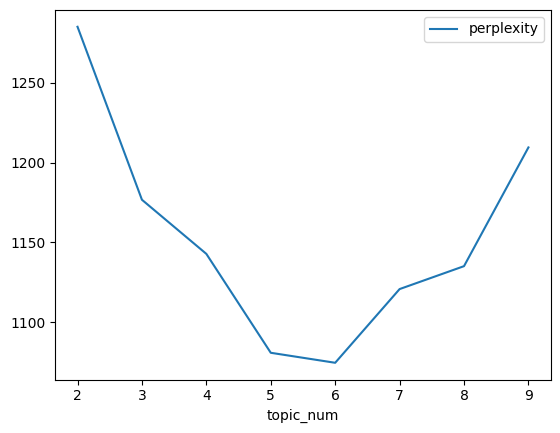

In [ ]:
result.plot.line(x='topic_num', y='perplexity')

<Axes: xlabel='topic_num'>

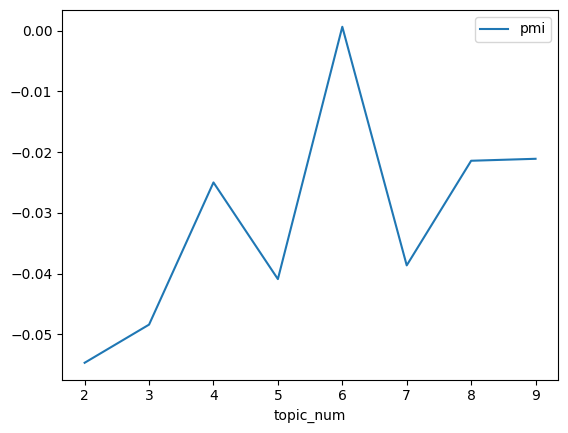

In [ ]:
result.plot.line(x='topic_num', y='pmi')

就訓練結果來看，perplexity 在 6 不錯，coherence 最高則是 6

## 視覺化呈現結果

In [ ]:
best_model = LdaModel(
    corpus = corpus,
    num_topics = 6,
    id2word=dictionary,
    random_state = 1500,
    passes = 5 # 訓練次數
    )

2025-04-19 16:03:13,927 : INFO : using symmetric alpha at 0.16666666666666666
2025-04-19 16:03:13,928 : INFO : using symmetric eta at 0.16666666666666666
2025-04-19 16:03:13,931 : INFO : using serial LDA version on this node
2025-04-19 16:03:13,942 : INFO : running online (multi-pass) LDA training, 6 topics, 5 passes over the supplied corpus of 16310 documents, updating model once every 2000 documents, evaluating perplexity every 16310 documents, iterating 50x with a convergence threshold of 0.001000
2025-04-19 16:03:13,943 : INFO : PROGRESS: pass 0, at document #2000/16310
2025-04-19 16:03:14,590 : INFO : merging changes from 2000 documents into a model of 16310 documents
2025-04-19 16:03:14,594 : INFO : topic #0 (0.167): 0.029*"工作" + 0.014*"方式" + 0.013*"應徵" + 0.012*"推定" + 0.012*"單位" + 0.012*"空白" + 0.012*"砍除" + 0.010*"內容" + 0.010*"資訊" + 0.009*"聯絡"
2025-04-19 16:03:14,595 : INFO : topic #1 (0.167): 0.030*"工作" + 0.016*"方式" + 0.012*"推定" + 0.011*"聯絡" + 0.011*"單位" + 0.011*"砍除" + 0.011*"第一項

In [ ]:
pyLDAvis.enable_notebook()
p = pyLDAvis.gensim_models.prepare(best_model, corpus, dictionary)
p

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5     -0.299535  0.193875       1        1  37.793742
4      0.245920  0.018139       2        1  23.896788
1      0.227101  0.005809       3        1  20.401931
2     -0.098888  0.063449       4        1   8.489953
0      0.134771 -0.000937       5        1   5.249268
3     -0.209368 -0.280334       6        1   4.168318, topic_info=    Term          Freq         Total Category  logprob  loglift
34    工作  74360.000000  74360.000000  Default  30.0000  30.0000
321   推定  23439.000000  23439.000000  Default  29.0000  29.0000
50    方式  27690.000000  27690.000000  Default  28.0000  28.0000
23    單位  20105.000000  20105.000000  Default  27.0000  27.0000
36    工資  15885.000000  15885.000000  Default  26.0000  26.0000
..   ...           ...           ...      ...      ...      ...
153   提供    998.682697   8272.551621   Topic6  -4.9727   1.0634
73    聯絡   1056.003498  20408.887353   Topic6  -4.9169   0.2162
12    內容    978.784041  23126.742818   Topic6  -4.9929   0.0152
157   條件    919.634782   9214.971541   Topic6  -5.0552   0.8730
50    方式    902.400500  27690.074502   Topic6  -5.0741  -0.2461

[476 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
210       2  0.544514    一律
210       3  0.409652    一律
210       4  0.011905    一律
210       5  0.033849    一律
213       1  0.003195   一次性
...     ...       ...   ...
5417      4  0.972331  高速公路
5417      5  0.012004  高速公路
672       2  0.027680    齊虹
672       3  0.941125    齊虹
672       5  0.027680    齊虹

[1668 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 5, 2, 3, 1, 4])

可以看(2,3,5) 很接近，試試看跑四個主題

In [ ]:
model_5 = LdaModel(
    corpus = corpus,
    num_topics = 4,
    id2word=dictionary,
    random_state = 1500,
    passes = 4 # 訓練次數
    )
pyLDAvis.enable_notebook()
p = pyLDAvis.gensim_models.prepare(model_5, corpus, dictionary)
p

2025-04-19 16:03:44,013 : INFO : using symmetric alpha at 0.25
2025-04-19 16:03:44,014 : INFO : using symmetric eta at 0.25
2025-04-19 16:03:44,038 : INFO : using serial LDA version on this node
2025-04-19 16:03:44,066 : INFO : running online (multi-pass) LDA training, 4 topics, 4 passes over the supplied corpus of 16310 documents, updating model once every 2000 documents, evaluating perplexity every 16310 documents, iterating 50x with a convergence threshold of 0.001000
2025-04-19 16:03:44,066 : INFO : PROGRESS: pass 0, at document #2000/16310
2025-04-19 16:03:44,648 : INFO : merging changes from 2000 documents into a model of 16310 documents
2025-04-19 16:03:44,650 : INFO : topic #0 (0.250): 0.029*"工作" + 0.014*"方式" + 0.013*"推定" + 0.012*"應徵" + 0.012*"空白" + 0.011*"單位" + 0.011*"砍除" + 0.010*"內容" + 0.010*"聯絡" + 0.010*"資訊"
2025-04-19 16:03:44,651 : INFO : topic #1 (0.250): 0.030*"工作" + 0.015*"方式" + 0.013*"推定" + 0.011*"聯絡" + 0.011*"單位" + 0.011*"國定假日" + 0.010*"第一項" + 0.010*"空白" + 0.010*"情形" 

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.298481 -0.082304       1        1  47.337103
3     -0.271188 -0.126857       2        1  37.724702
2      0.007553 -0.060090       3        1  10.235505
0     -0.034846  0.269251       4        1   4.702689, topic_info=    Term          Freq         Total Category  logprob  loglift
34    工作  75783.000000  75783.000000  Default  30.0000  30.0000
50    方式  27286.000000  27286.000000  Default  29.0000  29.0000
54    時間  17622.000000  17622.000000  Default  28.0000  28.0000
33    小時  17064.000000  17064.000000  Default  27.0000  27.0000
12    內容  23471.000000  23471.000000  Default  26.0000  26.0000
..   ...           ...           ...      ...      ...      ...
73    聯絡   1214.473612  20599.332482   Topic4  -4.8977   0.2261
12    內容   1123.610761  23471.035546   Topic4  -4.9755   0.0178
157   條件    985.592330   9250.548176   Topic4  -5.1066   0.8178
50    方式   1096.363666  27286.554240   Topic4  -5.0000  -0.1574
108   分鐘    855.902038   5145.829581   Topic4  -5.2476   1.2632

[312 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
210       1  0.984286    一律
210       2  0.000088    一律
210       3  0.014897    一律
210       4  0.000789    一律
213       1  0.995324   一次性
...     ...       ...   ...
207       3  0.003776   額滿將
207       4  0.993006   額滿將
5417      1  0.009930  高速公路
5417      3  0.983038  高速公路
5417      4  0.009930  高速公路

[977 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 4, 3, 1])

在嘗試後不同主題數量後，發現4個主題最為合適。

- 第一個主題主要與工作應徵和聯絡方式相關
- 第二個主題主要與半導體的產業發展相關
- 第三個主題主要與勞權相關
- 第四個主體與問卷研究、座談會相關

In [ ]:
# 取得每條新聞的主題分佈
topics_doc = model_5.get_document_topics(corpus)
topics_doc[100]

[(1, 0.97264475), (2, 0.02634671)]

In [ ]:
# 把 gensim 的稀疏表示法轉成稀疏矩陣
m_theta = corpus2csc(topics_doc).T.toarray() # 倒置讓shape變為(num_docs, num_topics)
m_theta

array([[0.        , 0.33038548, 0.66557795, 0.        ],
       [0.9956888 , 0.        , 0.        , 0.        ],
       [0.        , 0.99831349, 0.        , 0.        ],
       ...,
       [0.        , 0.        , 0.        , 0.99198657],
       [0.        , 0.        , 0.        , 0.9972536 ],
       [0.        , 0.        , 0.17628665, 0.82183146]])

In [ ]:
# 將主題的機率分布轉換成主題標籤
data['topic_label'] = m_theta.argmax(axis=1) + 1

# 儲存分類結果
data.to_csv('./raw_data/topicData.csv',index=False)

### 固定各topic_label 所代表的顏色

In [ ]:
# 取得所有唯一的 topic_label，並排序保證一致性
all_topics = sorted(data['topic_label'].unique())

# 使用較深的 colormap，例如 'tab20' 
cmap = plt.cm.get_cmap('tab20', len(all_topics))
colors = {topic: cmap(i) for i, topic in enumerate(all_topics)}

/var/folders/tz/hplj27qd26n9qxr1cd83m32c0000gn/T/ipykernel_12814/893968679.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab20', len(all_topics))


### 統計個主題數量

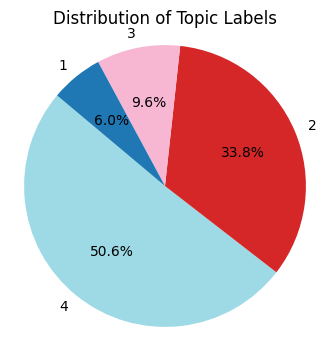

In [ ]:
data = pd.read_csv("./raw_data/topicData.csv")
# 日期轉換與欄位整理
data['artDate'] = pd.to_datetime(data['artDate'])
value_counts = data[data['artDate'].dt.year >= 2024]['topic_label'].value_counts()
# 畫出圓餅圖
plt.figure(figsize=(4, 4))
plt.pie(value_counts, labels=value_counts.index, autopct='%1.1f%%', startangle=140, colors=[colors[col] for col in value_counts.index])
plt.title('Distribution of Topic Labels')
plt.axis('equal')  # 讓圓餅圖是圓形的
plt.show()

### 2024 - 2025 的趨勢

Text(0.5, 1.0, '2024 - 2025 topic trend')

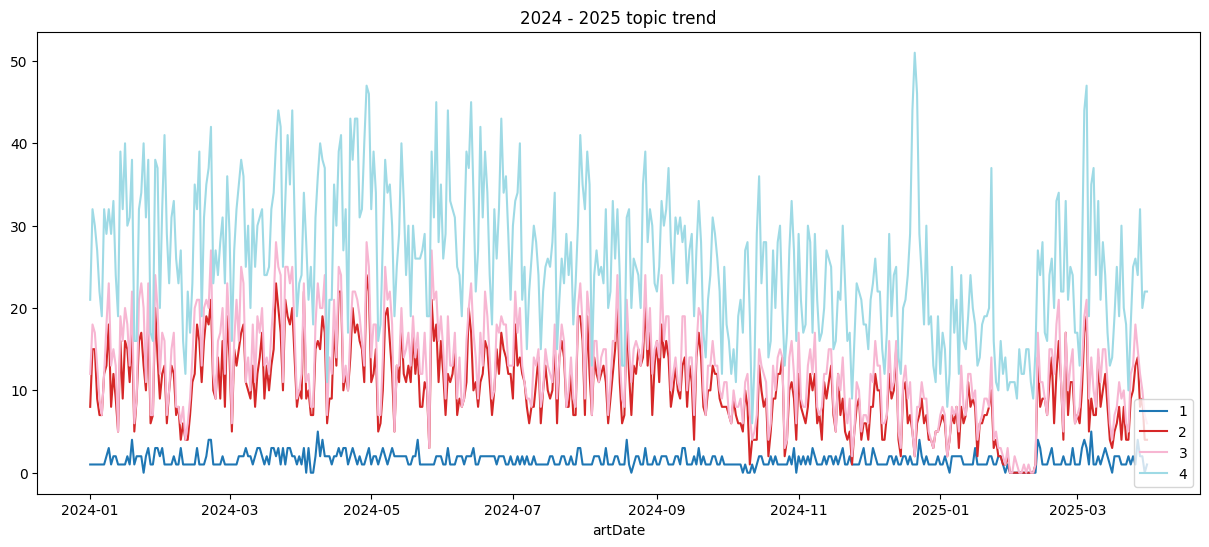

In [ ]:
date_topic = data[data['artDate'].dt.year >= 2024].groupby(data['artDate'].dt.date)['topic_label'].value_counts().unstack()
fig, ax = plt.subplots(figsize=(15, 6))
date_topic.plot.line(ax=ax, stacked=True, color=[colors[col] for col in date_topic.columns])
ax.legend(loc='lower right')
ax.set_title("2024 - 2025 topic trend")

1.	主題 4 主導整體討論量，代表問卷與活動徵才最頻繁出現。
2.	主題 2 & 3 呈現正相關波動，反映出產業發展與勞權待遇常共同被提及。
3.	主題 1 極低，顯示明確求職/聯絡訊息少見，可能散見於其他渠道。
4.	2025 年初多主題出現缺口，可能與過年的長假相關

### 各月主題分布

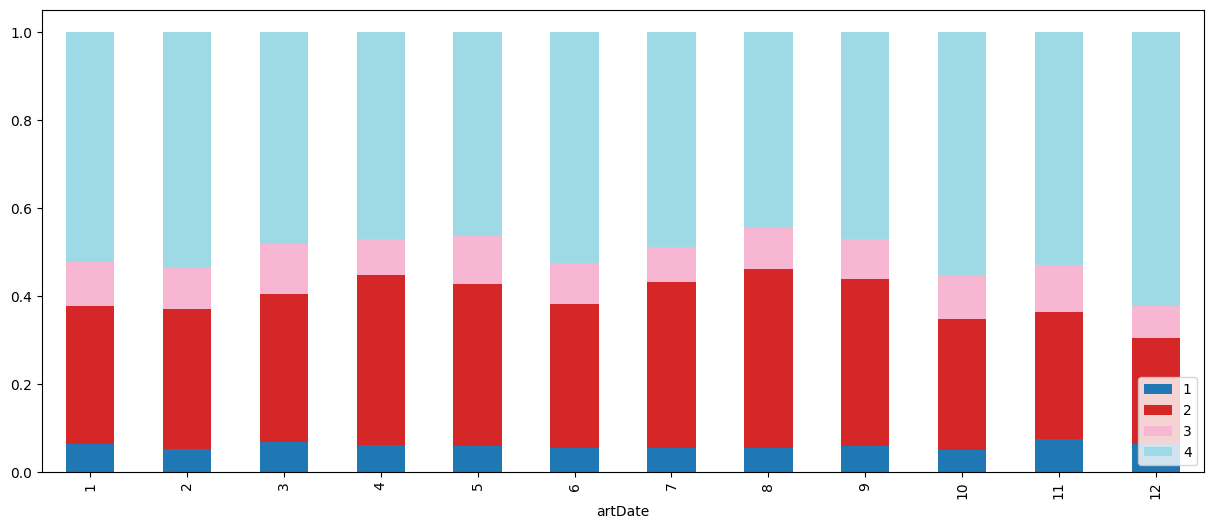

In [ ]:
month_topic =  data[data['artDate'].dt.year >= 2024].groupby(data['artDate'].dt.month)['topic_label'].value_counts(normalize=True).unstack()
fig, ax = plt.subplots(figsize=(15, 6))
month_topic.plot.bar(ax=ax, stacked=True, color=[colors[col] for col in month_topic.columns])
ax.legend(loc='lower right')

1.	主題4（淺藍）：
	- 幾乎每個月份都佔了最大比例，尤其在第12月更明顯，顯示問卷研究或座談會招募的訊息非常頻繁且穩定。
2.	主題2（紅）：
	- 佔比也相當高，特別是在第4、8、9月等月份，這些月份半導體相關的話題討論明顯增多。
	- 第12月大幅下降，可能表示年底與產業發展相關的討論減少。
3.	主題3（粉紅）：
	- 雖然佔比較小，但在各月份相對穩定，顯示勞權和待遇的議題有一定關注度。
	- 第5和第9月稍微上升，可能與某些事件或新聞相關。
4.	主題1（深藍）：
	- 全年佔比較小，但在第1、3、11月略微上升，可能與年初/年末轉職季節相關，工作機會和聯絡方式的訊息較多。
- 第一個主題主要與工作應徵的資訊相關
- 第二個主題主要與半導體的產業發展相關
- 第三個主題主要與勞權、待遇相關
- 第四個主題與問卷研究、座談會招募相關

### 不同類別版被標記的比例分布

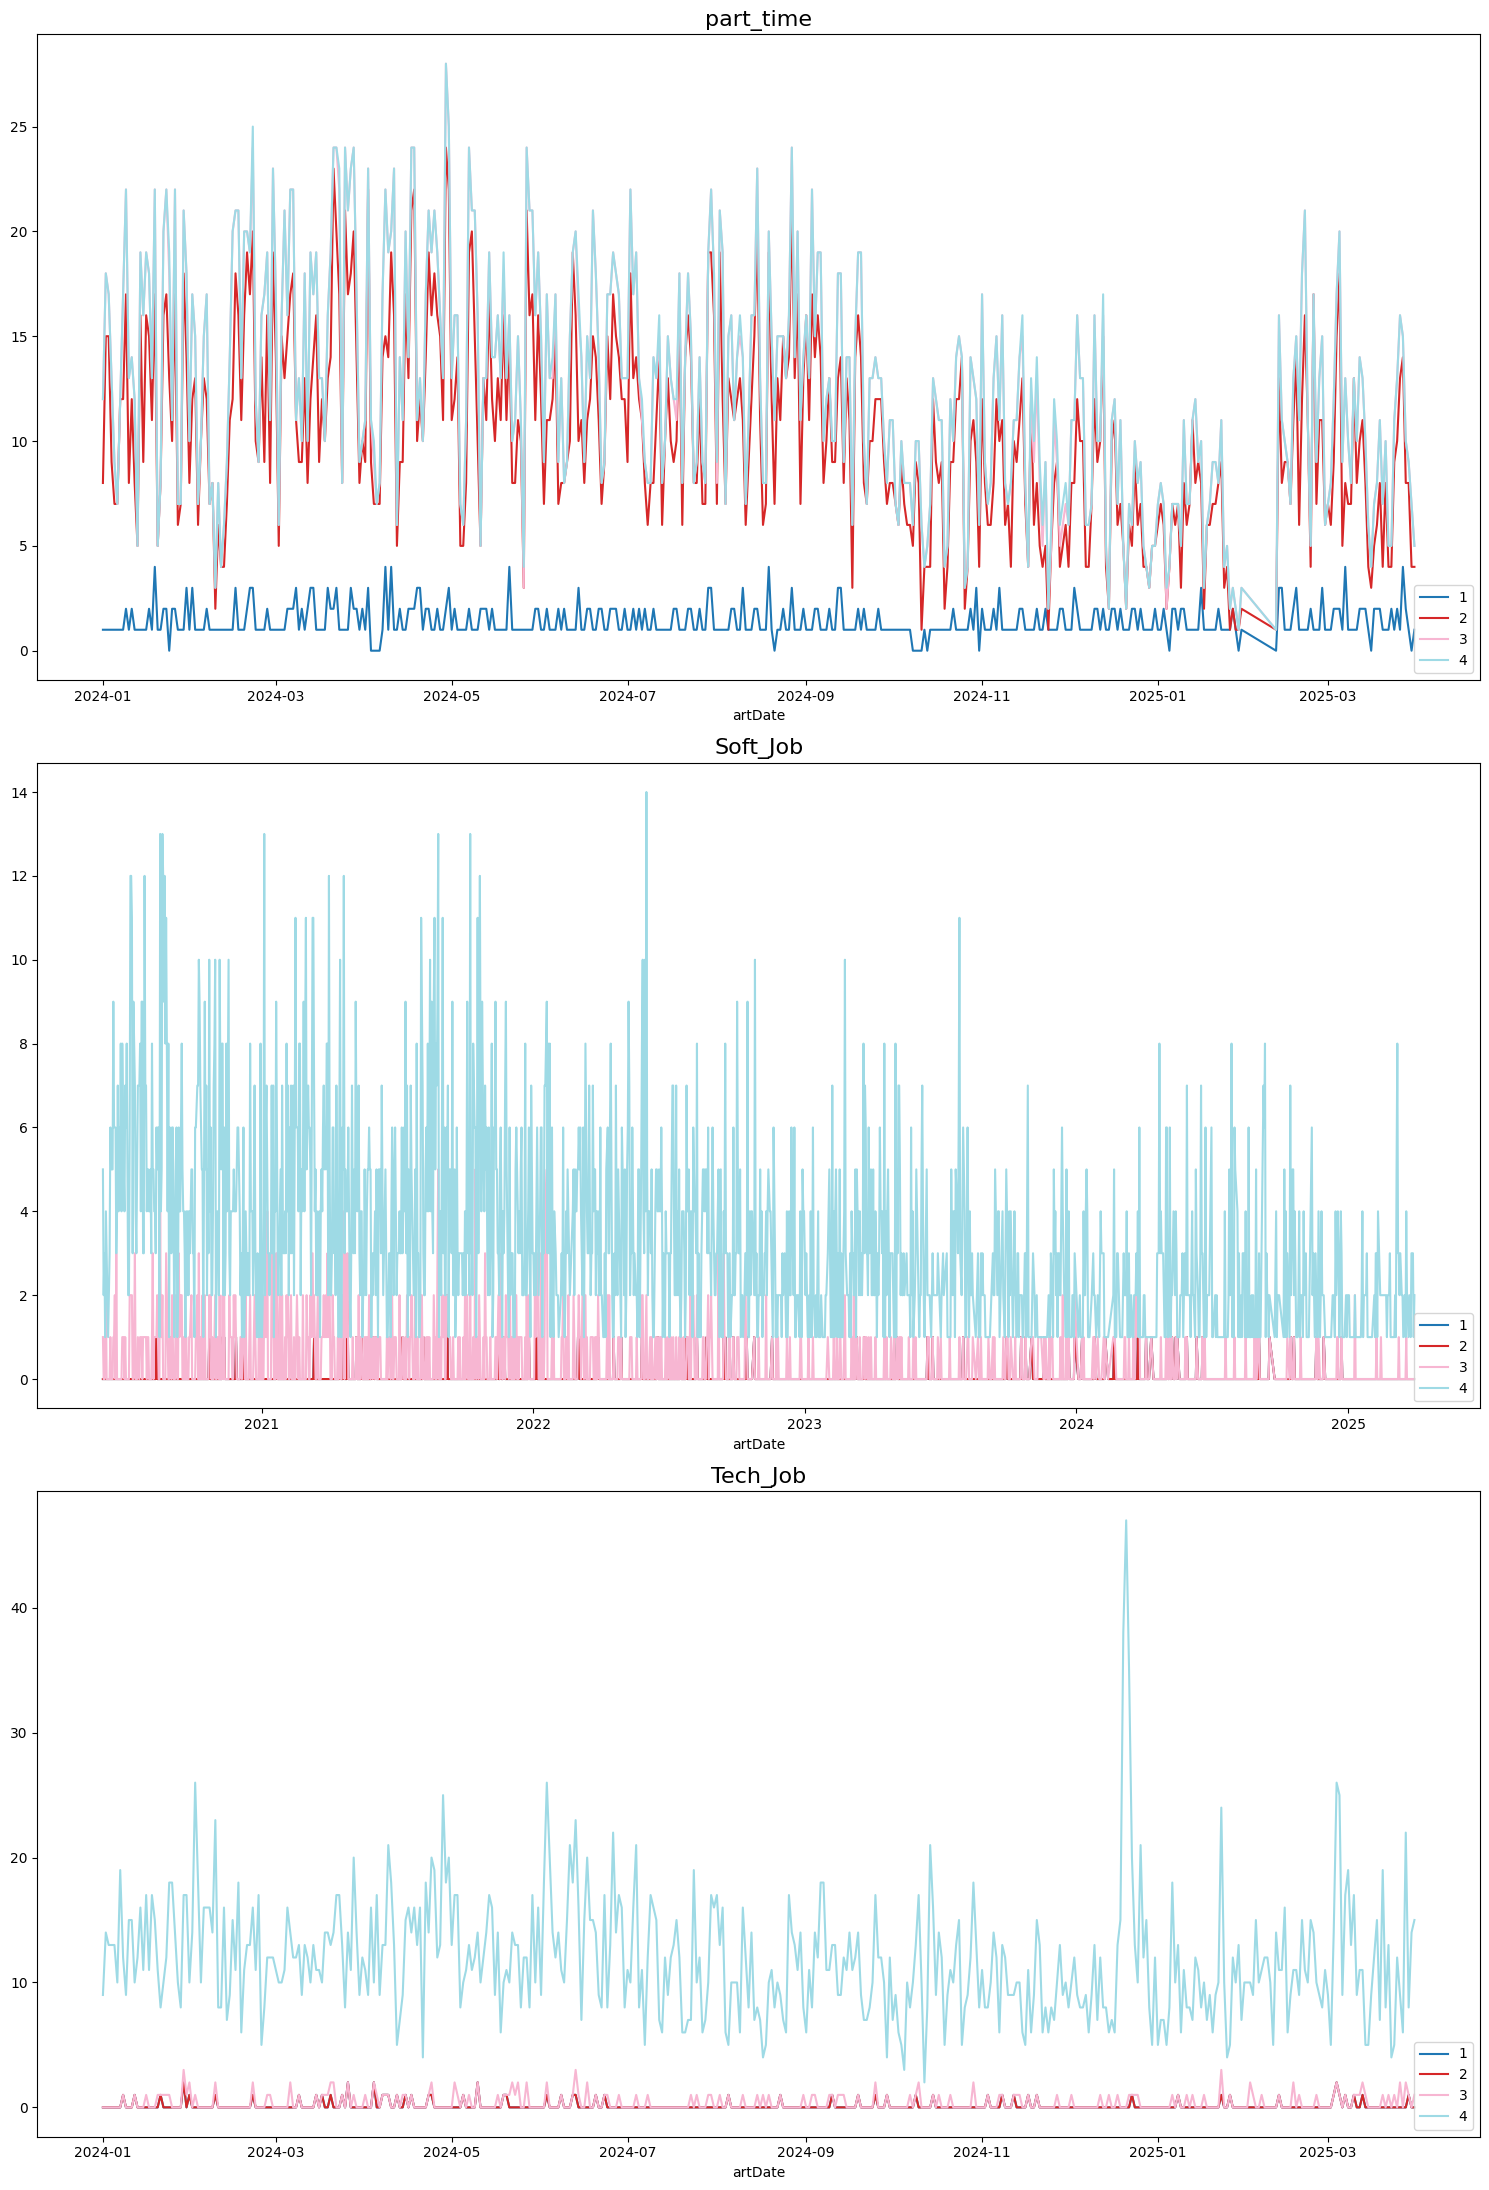

In [ ]:
# 畫三張圖（固定顏色）
fig, ax = plt.subplots(3, 1, figsize=(15, 22))

for i, cat in enumerate(data['artCatagory'].unique()):
    date_topic = (
        data[(data['artCatagory'] == cat) & (data['artDate'].dt.year >= 2024)]
        .groupby(data['artDate'].dt.date)['topic_label']
        .value_counts()
        .unstack()
        .reindex(columns=all_topics, fill_value=0)  # 確保所有主題都出現
    )
    
    # 繪圖（固定顏色順序）
    date_topic.plot.line(
        ax=ax[i],
        stacked=True,
        color=[colors[col] for col in date_topic.columns]
    )
    ax[i].set_title(f'{cat}', fontsize=16)
    ax[i].legend(loc='lower right')
plt.tight_layout()
plt.show()

# 4. GuidedLDA

In [ ]:
import guidedlda

In [ ]:
p

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.298481 -0.082304       1        1  47.337103
3     -0.271188 -0.126857       2        1  37.724702
2      0.007553 -0.060090       3        1  10.235505
0     -0.034846  0.269251       4        1   4.702689, topic_info=    Term          Freq         Total Category  logprob  loglift
34    工作  75783.000000  75783.000000  Default  30.0000  30.0000
50    方式  27286.000000  27286.000000  Default  29.0000  29.0000
54    時間  17622.000000  17622.000000  Default  28.0000  28.0000
33    小時  17064.000000  17064.000000  Default  27.0000  27.0000
12    內容  23471.000000  23471.000000  Default  26.0000  26.0000
..   ...           ...           ...      ...      ...      ...
73    聯絡   1214.473612  20599.332482   Topic4  -4.8977   0.2261
12    內容   1123.610761  23471.035546   Topic4  -4.9755   0.0178
157   條件    985.592330   9250.548176   Topic4  -5.1066   0.8178
50    方式   1096.363666  27286.554240   Topic4  -5.0000  -0.1574
108   分鐘    855.902038   5145.829581   Topic4  -5.2476   1.2632

[312 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
210       1  0.984286    一律
210       2  0.000088    一律
210       3  0.014897    一律
210       4  0.000789    一律
213       1  0.995324   一次性
...     ...       ...   ...
207       3  0.003776   額滿將
207       4  0.993006   額滿將
5417      1  0.009930  高速公路
5417      3  0.983038  高速公路
5417      4  0.009930  高速公路

[977 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 4, 3, 1])

In [ ]:
word2id = dictionary.token2id

In [ ]:
# 嘗試將軟體與硬體分開
seed_topic_list = [
    ["受訪者", "訪談", "訪問", "實驗", "抽獎"],
    ["聯絡人", "連結", "電子郵件", "聯絡"],
    ["晶片","技術","英特爾","台積電"],
    ["軟體","資訊","網站","系統", "開發","專案"],
    ["面試", "加班費", "履歷", "職缺"]
]
seed_topics = {}
for t_id, st in enumerate(seed_topic_list):
    for word in st:
        seed_topics[word2id[word]] = t_id

In [ ]:
# guidedlda 需要 DTM 格式作為 input，因此這邊利用 corpus2dense() 方法進行轉換
X = corpus2dense(corpus, len(dictionary), len(corpus)).T.astype(np.int64)

In [ ]:
model = guidedlda.GuidedLDA(n_topics=5, n_iter=100, random_state=7, refresh=20)
model.fit(X, seed_topics=seed_topics, seed_confidence=1)

2025-04-19 15:48:34,425 : INFO : n_documents: 16310
2025-04-19 15:48:34,427 : INFO : vocab_size: 23261
2025-04-19 15:48:34,427 : INFO : n_words: 3460208
2025-04-19 15:48:34,427 : INFO : n_topics: 5
2025-04-19 15:48:34,427 : INFO : n_iter: 100
2025-04-19 15:48:34,569 : WARNING : all zero row in document-term matrix found
2025-04-19 15:48:48,928 : INFO : <0> log likelihood: -32236301
2025-04-19 15:48:51,118 : INFO : <20> log likelihood: -24644227
2025-04-19 15:48:53,125 : INFO : <40> log likelihood: -24503986
2025-04-19 15:48:55,176 : INFO : <60> log likelihood: -24410422
2025-04-19 15:48:57,211 : INFO : <80> log likelihood: -24380054
2025-04-19 15:48:59,208 : INFO : <99> log likelihood: -24372692


## 視覺化呈現結果

In [ ]:
# 整理／顯示主題模型結果
n_top_words = 10
topic_word = model.topic_word_
# 取得corpus全部的詞彙表
vocab = tuple(dictionary.token2id.keys())

for i, topic_dist in enumerate(topic_word):
    # 依照詞語機率從小到大排序，找出每個主題的前十個關鍵詞
    topic_words = np.array(vocab)[np.argsort(topic_dist)][: -(n_top_words + 1) : -1]
    print("Topic {}: {}".format(i, " ".join(topic_words)))
    

doc_topic = model.doc_topic_ # 文件-主題 分佈
term_freq = tuple(dictionary.cfs.values()) # 每個詞在整個語料中出現的總次數
doc_len = [sum(v for k, v in doc) for doc in corpus] # 每篇文章的長度

## LDAvis
pyLDAvis.enable_notebook()
p = pyLDAvis.prepare(topic_word, doc_topic, doc_len, vocab = vocab, term_frequency = term_freq)
p

Topic 0: 報名 活動 電話 台北市 人數 時間 通知 舉辦 車馬費 聯絡
Topic 1: 工作 推定 方式 砍除 空白 情形 單位 內容 聯絡 第一項
Topic 2: 台灣 美國 公司 晶片 表示 中國 半導體 台積電 員工 報導
Topic 3: 工作 時間 方式 公司 小時 經驗 每日 薪資 工時 職缺
Topic 4: 公司 工作 面試 問題 工程師 比較 覺得 知道 目前 時間


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.320117 -0.185114       1        1  48.197512
4     -0.190235 -0.048447       2        1  22.093062
2     -0.260746 -0.046222       3        1  16.249836
3      0.005578 -0.024535       4        1   8.936207
0      0.125285  0.304319       5        1   4.523383, topic_info=    Term          Freq         Total Category  logprob  loglift
34    工作  76840.000000  76840.000000  Default  30.0000  30.0000
73    聯絡  21299.000000  21299.000000  Default  29.0000  29.0000
50    方式  29140.000000  29140.000000  Default  28.0000  28.0000
321   推定  24094.000000  24094.000000  Default  27.0000  27.0000
54    時間  18625.000000  18625.000000  Default  26.0000  26.0000
..   ...           ...           ...      ...      ...      ...
12    內容   1557.893632  23920.861124   Topic5  -4.6098   0.3645
97    使用   1065.246657   5107.343227   Topic5  -4.9900   1.5284
157   條件   1084.233051   9565.435432   Topic5  -4.9723   0.9186
50    方式   1188.158579  29140.798115   Topic5  -4.8808  -0.1038
153   提供    985.303943   8273.116250   Topic5  -5.0680   0.9681

[427 rows x 6 columns], token_table=       Topic      Freq Term
term                       
430        1  0.011399   一下
430        2  0.986899   一下
430        3  0.001838   一下
431        1  0.009101   一些
431        2  0.921909   一些
...      ...       ...  ...
2604       4  0.999451   願受
771        5  0.999883   食用
2626       5  1.000050   飲用
20908      3  1.000287  馬斯克
21549      3  1.000257  魏哲家

[896 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 5, 3, 4, 1])

在使用seed list後，成功將軟體與硬體分開
- 第一個主題主要與工作應徵和聯絡方式相關
- 第二個主題主要與軟體業相關
- 第三個主題主要與半導體的產業發展相關
- 第四個主題主要與勞權福利相關
- 第五個主體與問卷研究、座談會相關

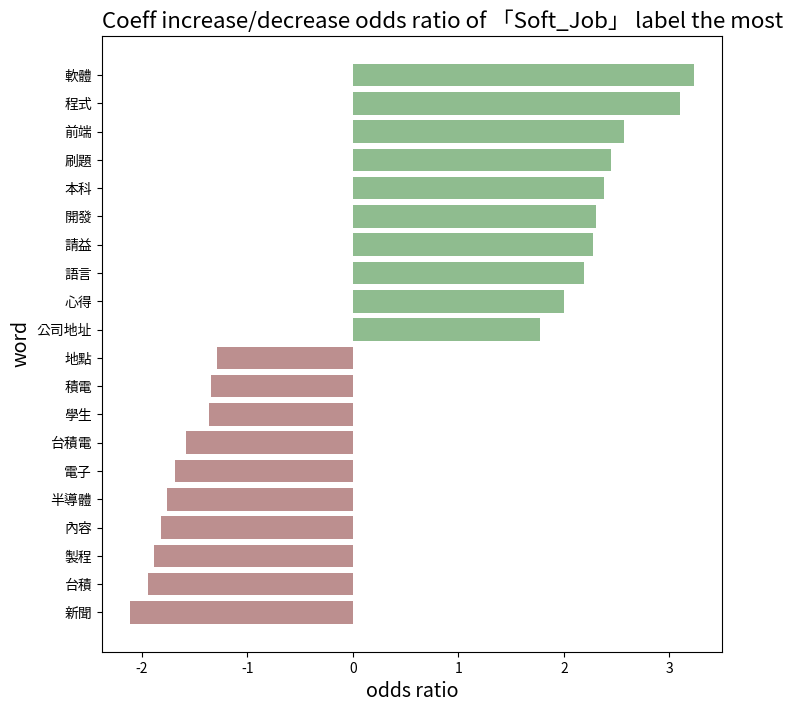

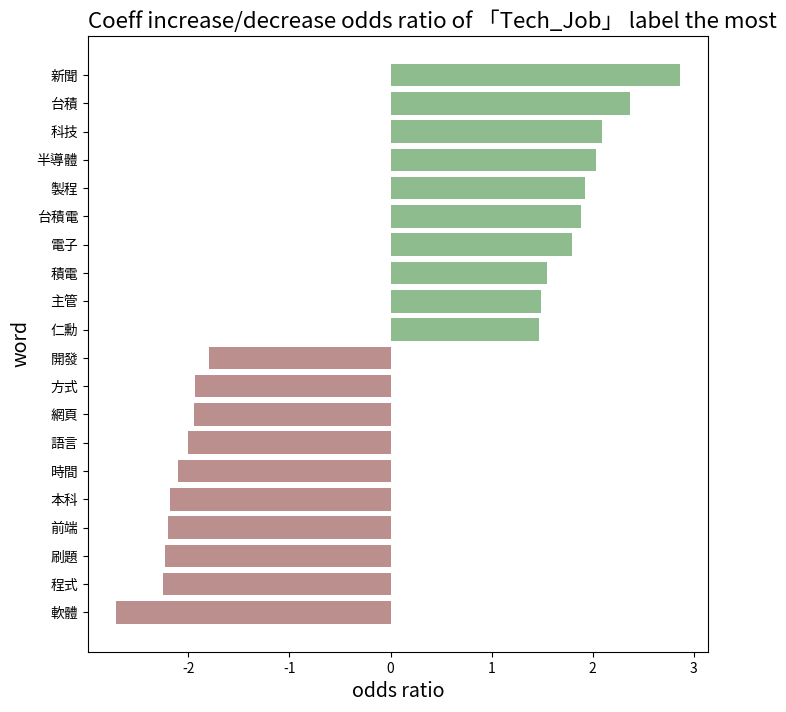

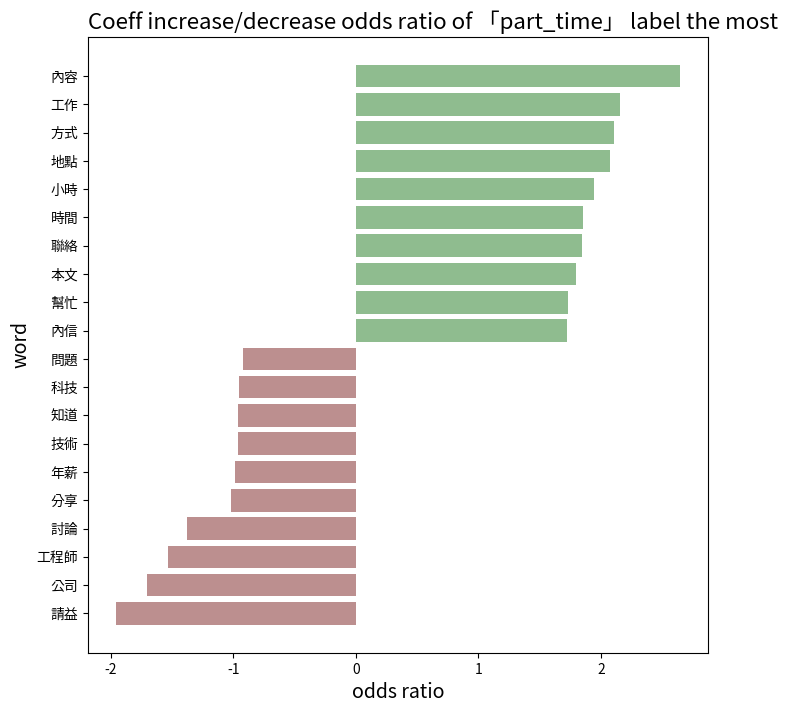

In [ ]:
plot_coef(logistic_reg_model=model_set['clf_logistic'], feature_names=vectorizer.get_feature_names_out(), top_n=10)